In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import probscale

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
from sklearn import metrics, linear_model
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from statsmodels.graphics.gofplots import qqplot
from scipy import stats
from scipy.stats import shapiro

In [3]:
house = pd.read_csv('housing.csv')
df = pd.DataFrame(house)

In [4]:
df.shape

(1460, 81)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [6]:
# Dropping those variables with less than 100 non-null values
df.drop(['Alley', 'PoolQC', 'MiscFeature'], axis=1, inplace=True)
df.shape

(1460, 78)

In [7]:
df.MSZoning.unique() # C denotes commercial properties

array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object)

In [8]:
# Delete all data with MSZoning = C, which appears to have 10 observations
df = df[df['MSZoning'] != 'C (all)']

In [9]:
# Notice a large number of null values in 'LotFrontage'. Examine the 'Lots' grouping.
df_lots = df[['LotFrontage', 'LotArea', 'LotConfig', 'LotShape']]
grouped_lots = df_lots.groupby(['LotShape'])
grouped_lots.mean()

,LotFrontage,LotArea
LotShape,,
IR1,76.003165,11901.635611
IR2,76.500000,23733.658537
IR3,138.428571,41338.200000
Reg,67.052257,8869.655022


In [10]:
grouped_lots2 = df_lots.groupby(['LotConfig'])
grouped_lots2.count()

,LotFrontage,LotArea,LotShape
LotConfig,,,
Corner,199,261,261
CulDSac,45,94,94
FR2,33,47,47
FR3,4,4,4
Inside,910,1044,1044


In [11]:
# Generate 'Lots' group where there are null 'LotFrontage' values
df_LotFrontage_NA = df_lots.loc[(df['LotFrontage'].isnull())]
df_LotFrontage_NA.columns

Index(['LotFrontage', 'LotArea', 'LotConfig', 'LotShape'], dtype='object')

In [12]:
df_LotFrontage_NA.LotFrontage.isnull().sum()

259

In [13]:
# A reasonable assumption is that LotFrontage is linked to LotConfig and LotShape, and
# the other 'Lot' variables have all observations
# So I will replace all NA in 'LotFrontage' with its mean based on the corresponding 'LotShape', which is indexed at 3
df_LotFrontage_NA['LotFrontage'] = df_LotFrontage_NA.apply(lambda x: 76.00 if (x[3] == 'IR1') 
                                                           else x[0], axis=1)
df_LotFrontage_NA['LotFrontage'] = df_LotFrontage_NA.apply(lambda x: 76.50 if (x[3] == 'IR2') 
                                                           else x[0], axis=1)
df_LotFrontage_NA['LotFrontage'] = df_LotFrontage_NA.apply(lambda x: 138.43 if (x[3] == 'IR3') 
                                                           else x[0], axis=1)
df_LotFrontage_NA['LotFrontage'] = df_LotFrontage_NA.apply(lambda x: 67.05 if (x[3] == 'Reg') 
                                                           else x[0], axis=1)

C:\Users\Tan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\Tan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\Tan\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

In [14]:
LotFront_fills = df_LotFrontage_NA.LotFrontage
LotFront_fills.count()

259

In [15]:
df.LotFrontage.isnull().sum()

259

In [16]:
# Filling the 'LotFrontage' null values with the LotFront_fills series in the given order of the data
df.loc[df.LotFrontage.isnull(), 'LotFrontage'] = LotFront_fills
df.LotFrontage.isnull().sum()

0

In [17]:
# Adding structure age variable depending if there was a major remodeling
df['Age'] = df.apply(lambda x: x['YrSold']-x['YearBuilt'] if (x['YearBuilt']<x['YearRemodAdd']) 
                                                           else (x['YrSold']-x['YearRemodAdd']), axis=1)

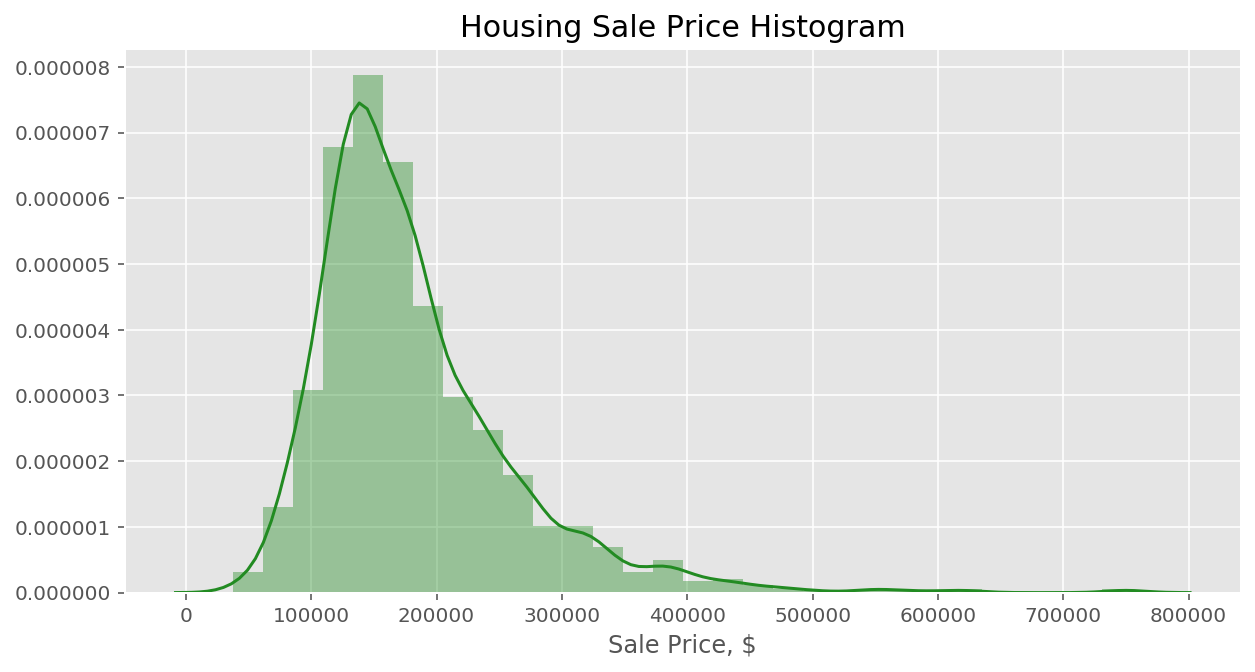

In [18]:
# The right-skew to the SalePrice is obvious in the histogram, showing that SalePrice has a long right tail
fig, ax = plt.subplots(figsize=(10,5))

sns.distplot(df.SalePrice, bins=30, kde=True, ax=ax, color='forestgreen')
plt.title('Housing Sale Price Histogram', fontsize=15)
plt.xlabel('Sale Price, $', fontsize=12);

### Creating variables on property area/size

In [19]:
# One of the chief factors affecting house prices in the size of the property.
# Here we examine the basement square footage variables. 
df[['BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', 'BsmtUnfSF']].head()

,BsmtFinSF1,BsmtFinSF2,TotalBsmtSF,BsmtUnfSF
0,706,0,856,150
1,978,0,1262,284
2,486,0,920,434
3,216,0,756,540
4,655,0,1145,490


In [20]:
# Here we examine the above ground square footage variables. The first column is obviously the sum of the other two.
df[['GrLivArea', '1stFlrSF', '2ndFlrSF']].head()

,GrLivArea,1stFlrSF,2ndFlrSF
0,1710,856,854
1,1262,1262,0
2,1786,920,866
3,1717,961,756
4,2198,1145,1053


In [21]:
df.GrLivArea.describe()

count    1450.000000
mean     1517.698621
std       525.154207
min       334.000000
25%      1131.250000
50%      1466.000000
75%      1779.000000
max      5642.000000
Name: GrLivArea, dtype: float64

In [22]:
# Create a total "finished" basement square footage variable
df['BaseLivArea'] = df.TotalBsmtSF - df.BsmtUnfSF

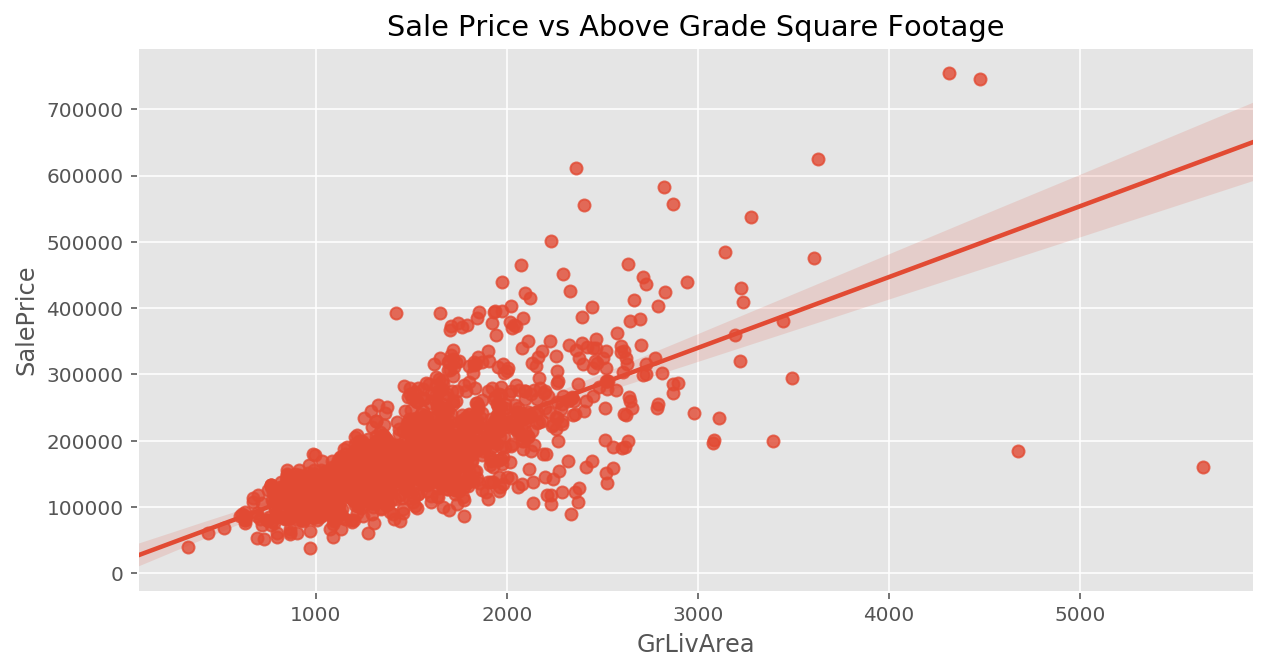

In [23]:
# Clear positive relationship between 'TSF' and 'SalePrice' variables, which is what one would expect.
# The larger the house, the higher its price, ceteris paribus
fig, ax = plt.subplots(figsize=(10,5))

sns.regplot(x="GrLivArea", y="SalePrice", data=df, ax=ax) 
ax.set_title('Sale Price vs Above Grade Square Footage');

In [24]:
# A simple linear regression of TSF on the SalePrice gives an R-squared of 50% by itself!
ols = LinearRegression()

X_GLA = df[['GrLivArea']]
y_SalePrice = df.SalePrice

ols.fit(X_GLA, y_SalePrice)
print("R-squared of Total Square Footage on Sale Price:", ols.score(X_GLA, y_SalePrice))

R-squared of Total Square Footage on Sale Price: 0.5021961681419125


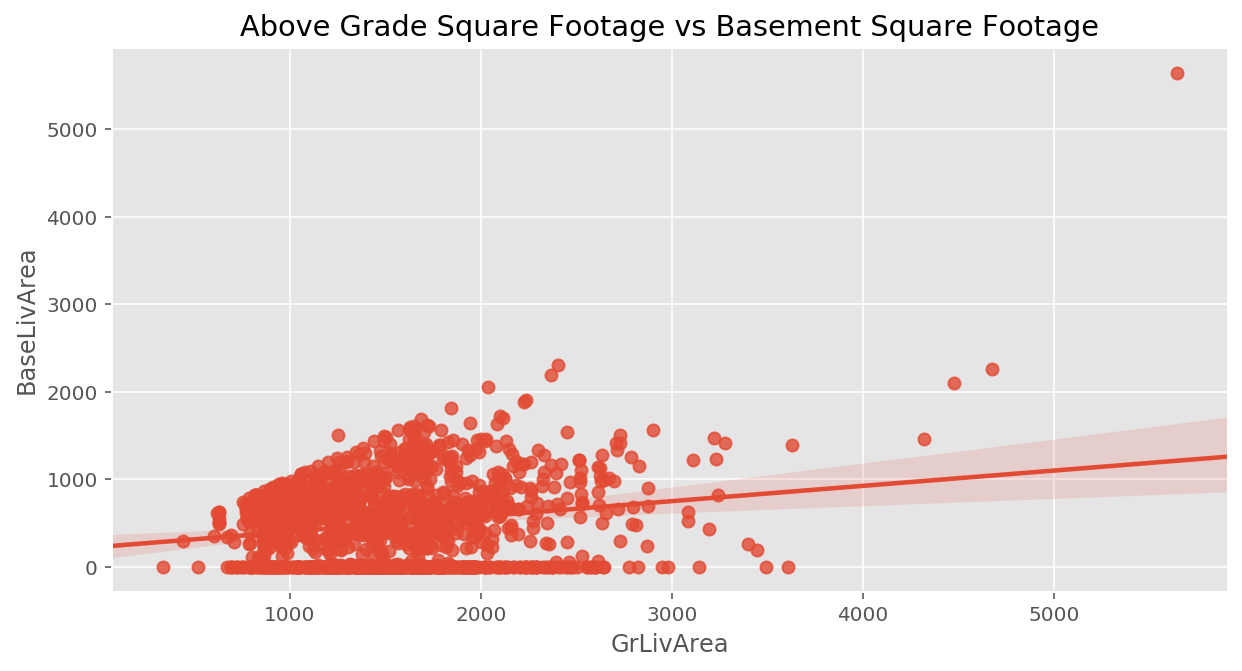

In [25]:
# There also appears to be a positive relationship between 'GrLivArea' and 'BaseLivArea', plus
# there seems to be greater variation in 'BaseLivArea' as 'GrLivArea' increases
fig, ax = plt.subplots(figsize=(10,5))

sns.regplot(x="GrLivArea", y="BaseLivArea", data=df, ax=ax) 
ax.set_title('Above Grade Square Footage vs Basement Square Footage');

In [26]:
df[['SalePrice', 'GrLivArea', 'BaseLivArea']].describe()

,SalePrice,GrLivArea,BaseLivArea
count,1450.000000,1450.000000,1450.000000
mean,181654.942069,1517.698621,492.033103
std,79176.485241,525.154207,476.317669
min,37900.000000,334.000000,0.000000
25%,130000.000000,1131.250000,0.000000
50%,163945.000000,1466.000000,468.000000
75%,214000.000000,1779.000000,794.750000
max,755000.000000,5642.000000,5644.000000


### Searching for outliers

In [27]:
# There are 22 instances of 'SalePrice' being 3 std above the mean
df.SalePrice[(df.SalePrice > 181654.9 + 3*79176.5)].count()

22

In [28]:
# But there are zero cases of the opposite
df.SalePrice[(df.SalePrice < 181654.9 - 2.5*79176.5)].count()

0

In [29]:
# There are 16 instances of 'GrLivArea' being 3 std above the mean, but zero of the opposite
df.GrLivArea[(df.GrLivArea > 1517.7 + 3*525.2)].count()

16

In [30]:
# There are 6 instances of 'GrLivArea' being 3 std above the mean, but obviously zero of the opposite
df.BaseLivArea[(df.BaseLivArea > 492 + 3*476.3)].count()

6

In [31]:
df.shape

(1450, 80)

In [32]:
df_exout = df[(df.SalePrice < 181654.9 + 3*79176.5)]

In [33]:
df_exout = df_exout[(df_exout.GrLivArea < 1517.7 + 3*525.2)]

In [34]:
df_exout = df_exout[(df_exout.BaseLivArea < 492 + 3*476.3)]

In [35]:
# All in all, 32 outliers are deleted
df_exout.shape 

(1418, 80)

It's no brainer that the larger the house, the higher the same price. Real estate professionals tend to speak about a property's value in per unit terms, in this case it would be the price per square foot. So I construct a price per square foot measure using 'GrLivArea' as the denominator. In the US, the basement square footage is typically not cited in housing sames and surveyors tend not to count basement size to a house's official square footage.

In [36]:
df_exout['PriceSF'] = df_exout.SalePrice / df_exout.GrLivArea

### Searching for non-commercial transactions

In [37]:
print(df_exout.SalePrice.mean())
print(df_exout.PriceSF.mean())

175739.98095909733
120.1945468907537


In [38]:
# 113 of these "abnormal" sale transactions are listed as "abnormal" or to family members, 
# and their mean SalePrice is well below the overall mean SalePrice
print(df_exout.SalePrice[(df_exout.SaleCondition == 'Abnorml') | (df_exout.SaleCondition == 'Family')].count())
df_exout.SalePrice[(df_exout.SaleCondition == 'Abnorml') | (df_exout.SaleCondition == 'Family')].mean()

113


144113.29203539822

In [39]:
# Even the mean 'PriceSF' of these "abnormal" sales is well below the overall mean
df_exout.PriceSF[(df_exout.SaleCondition == 'Abnorml') | (df_exout.SaleCondition == 'Family')].mean()

105.28059672751708

I chose to exclude these 113 "abnormal" sale transactions from the analysis. The reason is that if these transactions are not fully commercial in nature, then their inclusion in the dataset will detract from the "economic" or commercial relationship between a property's characteristic and its price. In other words, these "abnormal" transactions will introduce bias into the model estimates.

In [40]:
df_exout = df_exout[(df_exout.SaleCondition != 'Abnorml')]
df_exout = df_exout[(df_exout.SaleCondition != 'Family')]
df_exout.shape

(1305, 81)

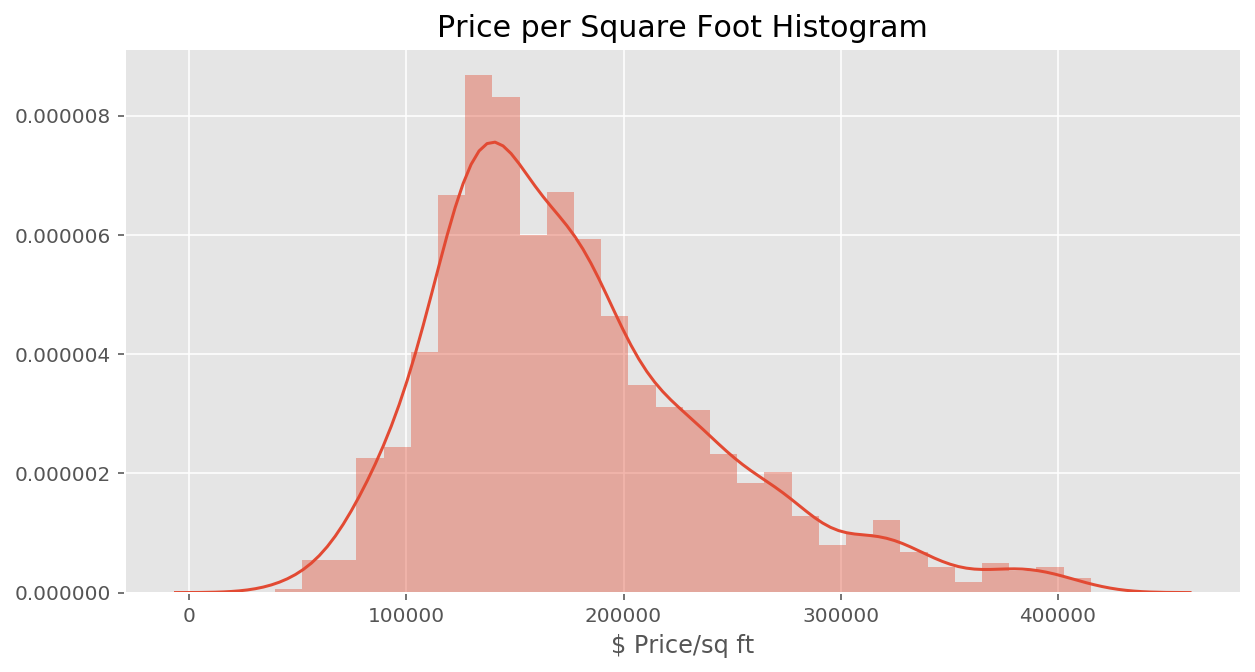

In [41]:
# Despite all the measures above, 'SalePrice' still very much skewed to the right
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(df_exout.SalePrice, bins=30, kde=True, ax=ax)
plt.title('Price per Square Foot Histogram', fontsize=15)
plt.xlabel('$ Price/sq ft', fontsize=12);

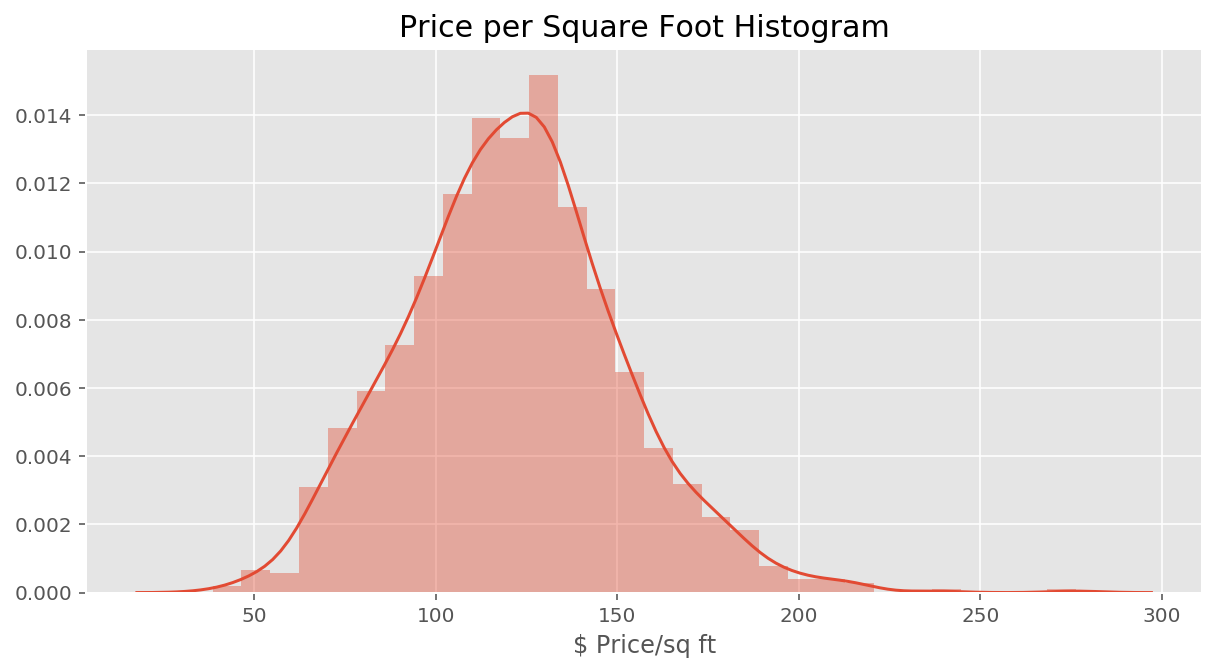

In [42]:
# Much less of a right-skew to the price per square foot, but still some
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(df_exout.PriceSF, bins=30, kde=True, ax=ax)
plt.title('Price per Square Foot Histogram', fontsize=15)
plt.xlabel('$ Price/sq ft', fontsize=12);

### Log transformation of the target variable

In [43]:
# Transform both sale price variables by taking the natural log to reduce the right-skew of the distributions
# The log transformation is also appropriate given that both variables have only non-zero positive values
df_exout['LnSalePrice'] = np.log(df_exout.SalePrice)
df_exout['LnPriceSF'] = np.log(df_exout.PriceSF)

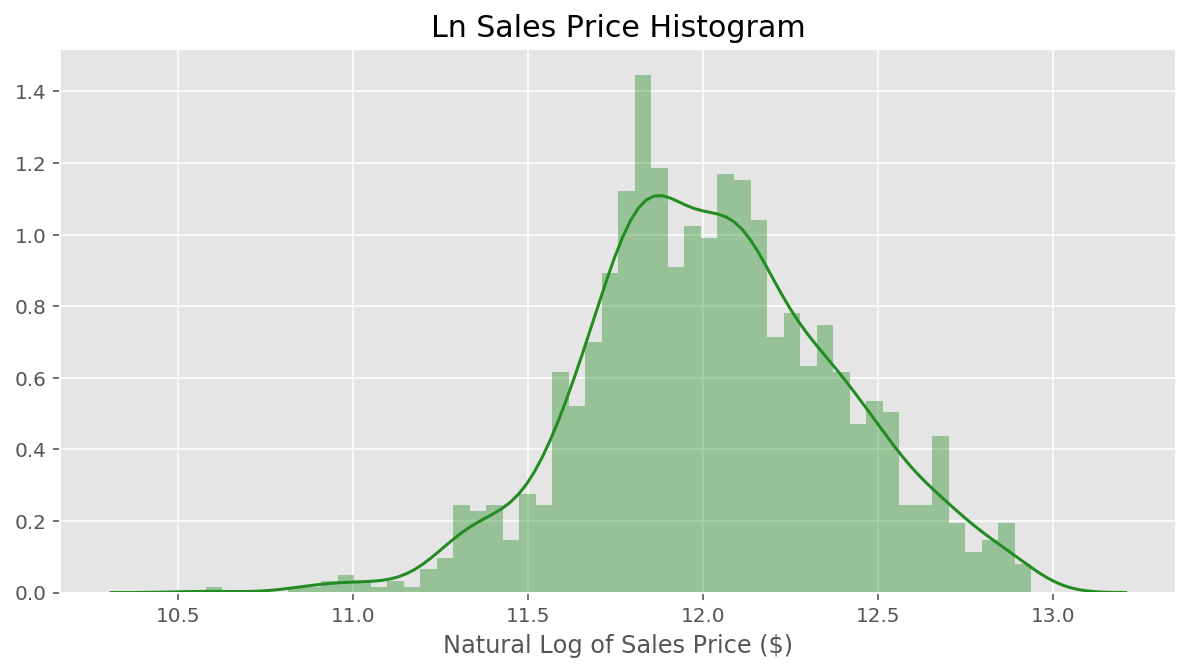

In [44]:
# The histogram of the ln SalePrice is clearly more symmetric
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(df_exout.LnSalePrice, bins=50, kde=True, ax=ax, color='forestgreen')
plt.title('Ln Sales Price Histogram', fontsize=15)
plt.xlabel('Natural Log of Sales Price ($)', fontsize=12);

C:\Users\Tan\Anaconda3\lib\site-packages\probscale\probscale.py:44: RuntimeWarning: invalid value encountered in sign
  return numpy.sign(z) * numpy.sqrt(numpy.sqrt(_b**2 - _c) - _b)
C:\Users\Tan\Anaconda3\lib\site-packages\probscale\probscale.py:32: RuntimeWarning: invalid value encountered in sign
  return numpy.sign(x) * numpy.sqrt(1.0 - numpy.exp(guts))


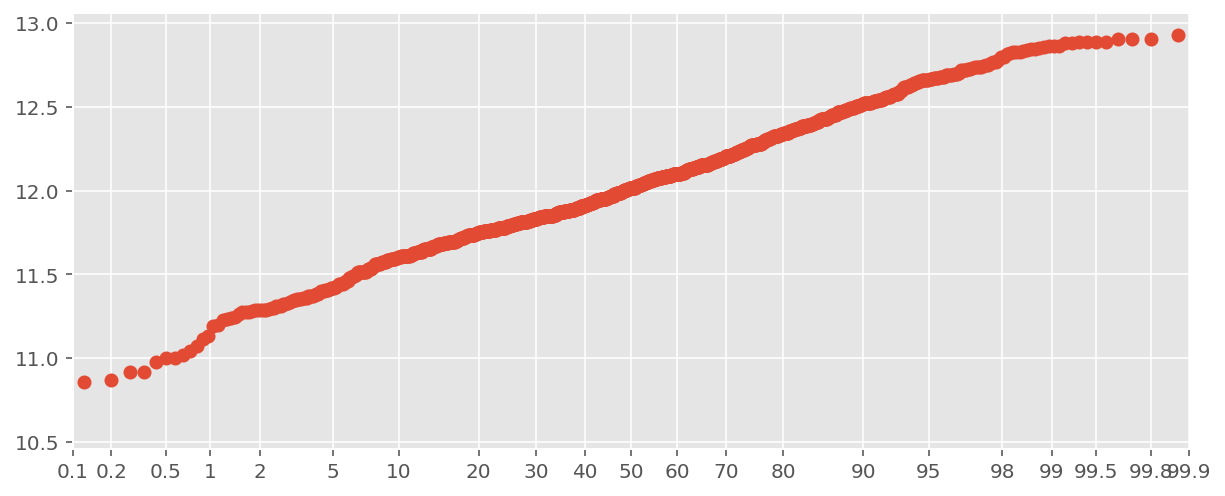

In [45]:
# Natural log of 'SalePrice' is closer to a normal distribution
fig, ax = plt.subplots(figsize=(10,4))
fig = probscale.probplot(df_exout.LnSalePrice, ax=ax, plottype='prob')

ax.set_xlim(0.1, 99.9)
ax.set_xscale('prob')
sns.despine(fig=fig)

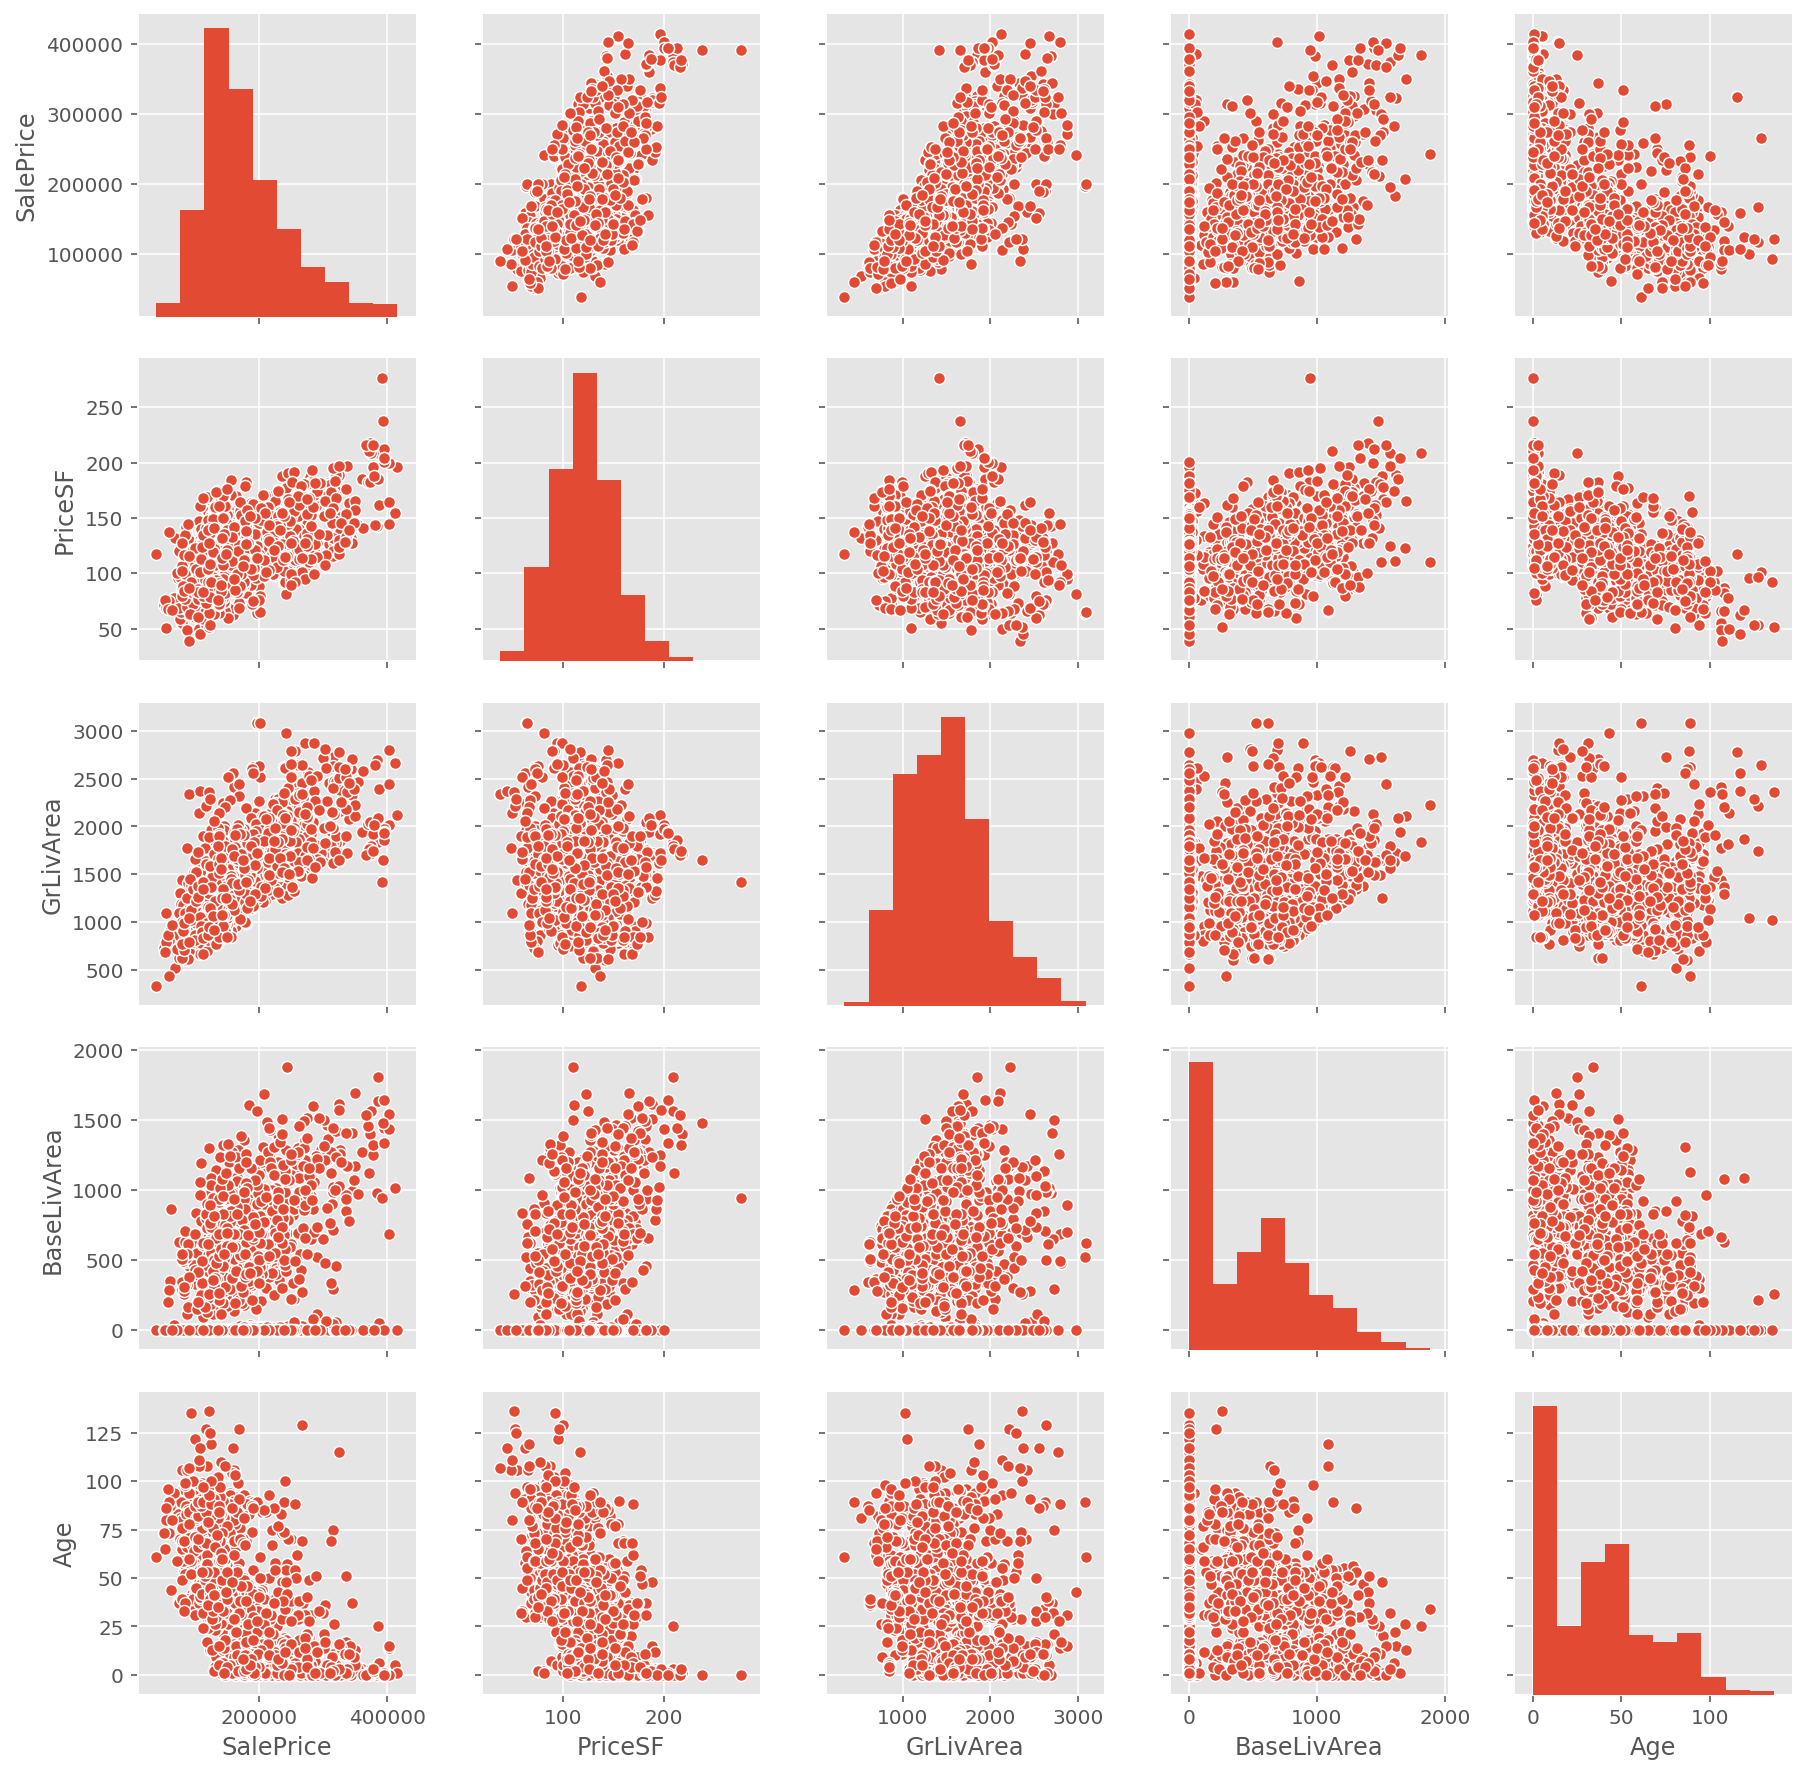

In [46]:
sns.pairplot(df_exout[['SalePrice', 'PriceSF', 'GrLivArea', 'BaseLivArea', 'Age']]);

Looking at the scatterplots of these key variables I have been working on, there are several notable observations. Although 'PriceSF' doesn't seem to a have a linear relationship with 'GrLivArea', it does appear to have a positive correlation with 'BaseLivArea'. This suggests that the size of the finished basement helps to raise 'PriceSF', which makes sense as it adds value to the property separate from 'GrLivArea'. Another interesting observation is that 'Age' seems to have more of a linear relationship with 'PriceSF' than with 'SalePrice'.

### Creating a "location" variable

In [47]:
# Examining the 'PriceSF' for the various neighbourhoods, it is obvious that the price premium differs significantly
# across them
neigh_mean = df_exout['PriceSF'].groupby(df_exout['Neighborhood']).count().sort_values()
neigh_mean

Neighborhood
Blueste      2
NPkVill      8
Veenker     11
BrDale      12
MeadowV     16
Blmngtn     17
StoneBr     20
SWISU       22
ClearCr     25
IDOTRR      26
NoRidge     32
Timber      34
Crawfor     44
Mitchel     44
BrkSide     54
SawyerW     54
NWAmes      64
NridgHt     67
Sawyer      68
Gilbert     76
Somerst     81
Edwards     90
OldTown     94
CollgCr    146
NAmes      198
Name: PriceSF, dtype: int64

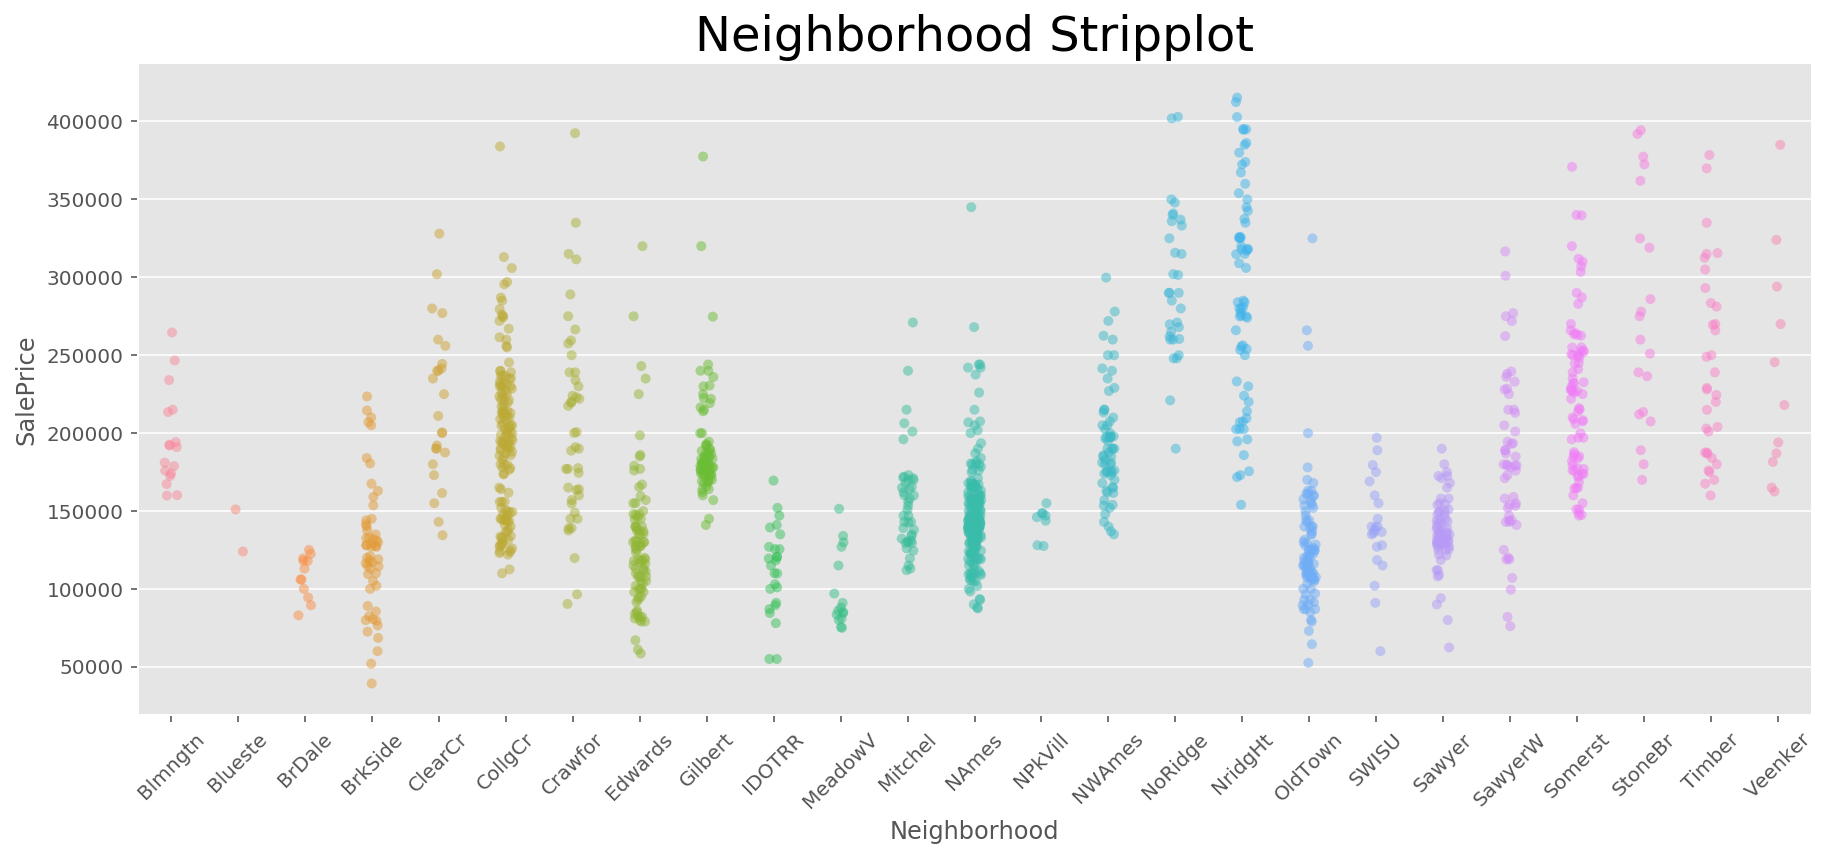

In [48]:
# Certain clusters of neighbourhoods do share similar distributions of 'SalePrice' and/or 'PriceSF'
fig, ax = plt.subplots(figsize=(15,6))

sns.stripplot(x = df_exout.Neighborhood, y = df_exout.SalePrice, order = np.sort(df_exout.Neighborhood.unique()),
              jitter=0.1, alpha=0.5, ax=ax)
plt.title('Neighborhood Stripplot', fontsize=24)
plt.xticks(rotation=45)
plt.show()

We know that one key determinant of house prices is "location, location, location," which may involve difficult to measure attributes such as socio-economic status, local amenities, good schools and/or neighbourhood aesthetics etc. Every house buyer understands that the geographical location of a house is a highly important factor in its price. There are however 25 separate neighbourhoods listed under the 'Neighborhood' variable, and it is probably not advisable to have 25 dummy variables on top of other relevant factors in the regression. So it is best we reduce the number of neighbourhood dummies. 

The problems with having a dummy of each neighbourhood are: 1) there are only a handful of observations for some neighbourhoods, with less than 20 for six neighbourhoods, and less than 50 for the majority of them; 2) there would be significant multicollinearity between certain neighbourhoods that share similar characteristics, as expressed through the distribution of the 'SalePrice' or 'PriceSF' (observable in the stripplot above). 

It is a problem analogous to whether a regression of car prices should incorporate individual brand dummies (i.e. individual dummies for Mercedes, BMW and Audi), or broader classes (i.e. 'top-end' or 'German'). It is probably advisable to try to collapse this neighbourhood factor into just several ordinal categories, and this is especially true in this case when the number of observations are simply inadequate to measure robustly each 25 neighbourhood's effects on housing prices. A collapsed 'Location' variable could offer more stable coefficient estimates, and hence reduce the model's variance across different samples. 

I was at first tempted to cluster the neighbourhoods by 'PriceSF', but that would be creating an explanatory variable that would be highly correlated to the target variable. A usual proxy would be to take average household income as a measure of a location/neighbourhood's desirability, but we do not have such data at hand. Instead, I looked at using some proxies from the available variables to construct the desirability of a neighbourhood, namely the variables on build quality and condition. The assumption behind this methodology is that the more "desirable" a neighbourhood, the better the quality of its housing structures and their condition. 

In [49]:
# Creating a new numeric ordinal variable for 'Functional'
def functional_numeric(x):
    if 'Typ' in x:
        return 8
    elif 'Min1' in x:
        return 7
    elif 'Min2' in x:
        return 6
    elif 'Mod' in x:
        return 5
    elif 'Maj1' in x:
        return 4
    elif 'Maj2' in x:
        return 3
    elif 'Sev' in x:
        return 2    
    else:
        return 1
    
df_exout['Functional_Num'] = df_exout.Functional.map(functional_numeric)

In [50]:
# Creating a new numeric ordinal variable for external conditon or 'ExterCond'
def extercond_numeric(x):
    if 'Ex' in x:
        return 5
    elif 'Gd' in x:
        return 4
    elif 'TA' in x:
        return 3
    elif 'Fa' in x:
        return 2
    else:
        return 1
    
df_exout['ExterCond_Num'] = df_exout.ExterCond.map(extercond_numeric)

In [51]:
# Creating a new numeric ordinal variable for external quality or 'ExterQual'
def exterqual_numeric(x):
    if 'Ex' in x:
        return 5
    elif 'Gd' in x:
        return 4
    elif 'TA' in x:
        return 3
    elif 'Fa' in x:
        return 2
    else:
        return 1
    
df_exout['ExterQual_Num'] = df_exout.ExterQual.map(exterqual_numeric)

In [52]:
print(df_exout['OverallQual'].mean())
print(df_exout['OverallCond'].mean())
print(df_exout['ExterQual_Num'].mean())
print(df_exout['ExterCond_Num'].mean())
print(df_exout['Functional_Num'].mean())

6.088888888888889
5.597701149425287
3.3969348659003833
3.0835249042145594
7.8421455938697315


Construct the location desirability proxy from the 5 individual mean-standardised variables listed above. The construction methodology implies a stronger weighting to the external quality/condition of the building.

In [53]:
df_exout['Location'] = ((df_exout['OverallQual']/df_exout['OverallQual'].mean()) 
            + (df_exout['OverallCond']/df_exout['OverallCond'].mean())
            + (df_exout['ExterQual_Num']/df_exout['ExterQual_Num'].mean())
            + (df_exout['ExterCond_Num']/df_exout['ExterCond_Num'].mean()) 
            + (df_exout['Functional_Num']/df_exout['Functional_Num'].mean()))

In [54]:
df_exout.Location.describe()

count    1305.000000
mean        5.000000
std         0.440090
min         2.090317
25%         4.754816
50%         5.049199
75%         5.272176
max         7.363704
Name: Location, dtype: float64

In [55]:
# The average 'Location' scores of the respective neighbourhoods
df_exout['Location'].groupby([df_exout.Neighborhood]).mean().sort_values()

Neighborhood
MeadowV    4.585017
Edwards    4.691133
Sawyer     4.763360
IDOTRR     4.775329
BrkSide    4.776543
BrDale     4.783028
SWISU      4.787494
Mitchel    4.817946
NAmes      4.830241
NPkVill    4.844138
ClearCr    4.931757
OldTown    4.964272
SawyerW    4.983582
Gilbert    5.039908
NWAmes     5.066630
Blueste    5.095613
CollgCr    5.134754
Timber     5.192908
Crawfor    5.210716
Blmngtn    5.242415
Somerst    5.263470
NoRidge    5.369973
StoneBr    5.402225
Veenker    5.404168
NridgHt    5.473913
Name: Location, dtype: float64

In [56]:
df_exout['SalePrice'].groupby([df_exout.Neighborhood]).count().sort_values()

Neighborhood
Blueste      2
NPkVill      8
Veenker     11
BrDale      12
MeadowV     16
Blmngtn     17
StoneBr     20
SWISU       22
ClearCr     25
IDOTRR      26
NoRidge     32
Timber      34
Crawfor     44
Mitchel     44
BrkSide     54
SawyerW     54
NWAmes      64
NridgHt     67
Sawyer      68
Gilbert     76
Somerst     81
Edwards     90
OldTown     94
CollgCr    146
NAmes      198
Name: SalePrice, dtype: int64

From the analysis above, there is a possible way to construct an ordinal measurement of locational desirability by using the percentiles of the distribution of the new 'Location' variable. I decided that with no additional information or insight, I should just allocate 4 ordinal values for 'Location': 1 (low), 2 (mid-low), 3 (mid-high) and 4 (high).

First, I sorted the 'Neighborhood' variable by the mean 'Location' values, then slice it in half near the median (5.05), so that there are 13 'Neighborhood' instances below and 12 above the median. This resulted in all neighbourhoods above "Gilbert" (as listed above), which had a mean 'Location' reading of 5.04, to fall into the 1 and 2 readings of 'Location'. I then arbitrary assigned 'Location' = 1 for the 6 lowest neighbourhoods by their mean 'Location' values, and 'Location' = 2 for the remaining 7.

As for the twelve neighbourhoods in the upper half of the 'Location' values, I divided them exactly in half, with the lower 6 in terms of their mean 'Location' values assigned 'Location' = 3, and the remainder assigned 'Location' = 4. 

In this way, I have created an ordinal 'Location' desirability score of 1 to 4. The number of observations in the data also do not appear to be too unbalanced across these four ranks, though 56.3% of the observations are in the first two 'Location' categories. That said, there was a right skew to the 'SalePrice' as discussed above, so there will likely be a smaller number of expensive neighborhoods.

In [57]:
def add_location(x):
    if 'MeadowV' in x or 'Edwards' in x or 'Sawyer' in x or 'IDOTRR' in x or 'Brkside' in x or 'BrDale' in x:
        return 1
    elif 'Swisu' in x or 'Mitchel' in x or 'NAmes' in x or 'NPkVill' in x or 'ClearCr' in x or 'OldTown' in x or 'SawyerW' in x:
        return 2
    elif 'Gilbert' in x or 'NWAmes' in x or 'Blueste' in x or 'CollgCr' in x or 'Timber' in x or 'Crawfor' in x:
        return 3
    else:
        return 4

In [58]:
df_exout['Location'] = df_exout.Neighborhood.map(add_location)

In [59]:
df_exout['Location'].value_counts()

2    369
3    366
4    304
1    266
Name: Location, dtype: int64

In [60]:
# Positive correlation between 'SalePrice' and 'PriceSF' with 'Location'
print(df_exout['SalePrice'].groupby(df_exout.Location).mean())
print(df_exout['PriceSF'].groupby(df_exout.Location).mean())

Location
1    137885.729323
2    148008.547425
3    200021.642077
4    225045.434211
Name: SalePrice, dtype: float64
Location
1    109.541033
2    113.199670
3    127.003093
4    135.353404
Name: PriceSF, dtype: float64


In [61]:
# Total mean house size also rises with 'Location', though the median tops out at Location 3
print(df_exout['GrLivArea'].groupby(df_exout.Location).mean())
print(df_exout['GrLivArea'].groupby(df_exout.Location).median())

Location
1    1291.958647
2    1369.097561
3    1611.994536
4    1660.259868
Name: GrLivArea, dtype: float64
Location
1    1204.0
2    1268.0
3    1620.5
4    1591.5
Name: GrLivArea, dtype: float64


So it does appear that the 'Location' score does tend to be positively correlated with house prices, and somewhat with property sizes too.

# Other feature engineering on sale year, seasonality, zoning, and proximinity to railways & artery roads

In [62]:
# Looking at the 'SalePrice' and 'PriceSF' grouped by 'YrSold', there is an obvious impact of the financial crisis 
# that hit in 2007-2008. The mean 'SoldPrice' and 'PriceSF' in 2009 and 2010 are still lower than those in 2007.
print(df_exout.SalePrice.groupby(df_exout.YrSold).mean())
print(df_exout.PriceSF.groupby(df_exout.YrSold).mean())

YrSold
2006    181017.818868
2007    180096.867110
2008    176970.775362
2009    177292.192810
2010    176052.656051
Name: SalePrice, dtype: float64
YrSold
2006    120.488764
2007    122.426367
2008    122.614105
2009    120.398094
2010    121.503130
Name: PriceSF, dtype: float64


In [63]:
# House prices were in an uptrend in 2006-2007, but fell in 2008 and have been moribund since. 
df_exout.PriceSF.groupby(df_exout.YrSold).mean().pct_change()

YrSold
2006         NaN
2007    0.016081
2008    0.001533
2009   -0.018073
2010    0.009178
Name: PriceSF, dtype: float64

In [64]:
# Thus, it might be useful to incorporate year dummies in the regression model
df_exout = pd.get_dummies(df_exout, columns=['YrSold'])

In [65]:
# Clear price differentials according to the discrete housing zones
df_exout.SalePrice.groupby(df_exout.MSZoning).mean()

MSZoning
FV    215071.508197
RH    119509.090909
RL    186742.365385
RM    125743.362694
Name: SalePrice, dtype: float64

In [66]:
# Creating a new ordinal variable of zoning, corresponding to the mean values from 'MSZoning'
# The FV observations in 'MSZoning' are a retirement community development, named "Floating Village", which appears to cater to
# wealthy retirees
def add_zoning(x):
    if 'RH' in x:
        return 1
    elif 'RM' in x:
        return 2
    elif 'RL' in x:
        return 3
    else:
        return 4

In [67]:
df_exout['Zoning'] = df_exout.MSZoning.map(add_zoning)

In [68]:
# No linear relationship between 'GrLivArea' or 'BaseLivArea' and 'Zoning'
print(df_exout.GrLivArea.groupby(df_exout.Zoning).mean())
df_exout.BaseLivArea.groupby(df_exout.Zoning).mean()

Zoning
1    1361.909091
2    1296.507772
3    1521.206731
4    1578.770492
Name: GrLivArea, dtype: float64


Zoning
1    345.272727
2    273.129534
3    522.082692
4    318.459016
Name: BaseLivArea, dtype: float64

In [69]:
# There appears to be a sizeable jump in prices in the low density and FV categories
print(df_exout.SalePrice.groupby(df_exout.Zoning).mean())
df_exout.PriceSF.groupby(df_exout.Zoning).mean()

Zoning
1    119509.090909
2    125743.362694
3    186742.365385
4    215071.508197
Name: SalePrice, dtype: float64


Zoning
1     94.739780
2    102.463516
3    124.403853
4    136.746839
Name: PriceSF, dtype: float64

In [70]:
# There is a relationship between 'Location' and 'Zoning' with Locations 3 and 4 
# primarily in zones 3 and 4 (low density and the retirement village)
df_exout.Location.groupby(df_exout.Zoning).value_counts()

Zoning  Location
1       1             6
        3             2
        4             2
        2             1
2       2            86
        1            63
        4            30
        3            14
3       3           350
        2           282
        4           211
        1           197
4       4            61
Name: Location, dtype: int64

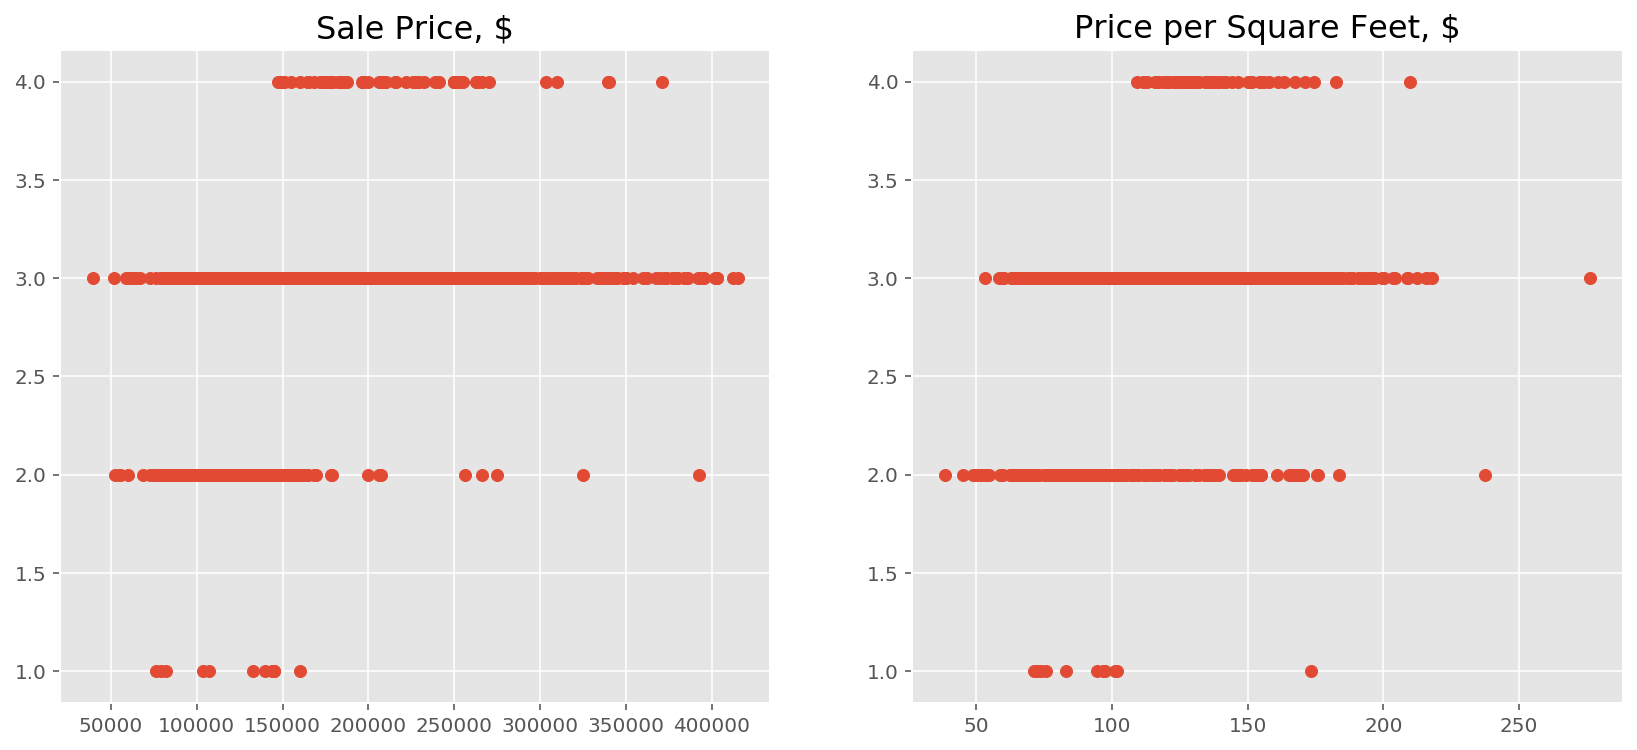

In [71]:
# There is a general increase inprices as we go from Zone 1 to 3, especially in mean 'PriceSF'
fig, ax = plt.subplots(ncols=2, figsize=(14, 6))

ax[0].scatter(df_exout.SalePrice, df_exout.Zoning)
ax[0].set_title('Sale Price, $', fontsize=16)
ax[1].scatter(df_exout.PriceSF, df_exout.Zoning)
ax[1].set_title('Price per Square Feet, $', fontsize=16)
#fig.suptitle('Sale Prices by Zone', fontsize=24)
plt.show()

In [72]:
# Analysis above suggests that it might be more useful to model 'Zoning' using dummies instead of an ordinal variable
df_exout['Zone_ordinal'] = df_exout['Zoning']
df_exout = pd.get_dummies(df_exout, columns=['Zoning'])

In [73]:
# The overwhelming majority of observations fall into the double-'Norm' category in terms of
# Condition1 and Condition2, which is a measure of environmental condition
df_exout.Condition1.groupby(df_exout.Condition2).value_counts()

Condition2  Condition1
Artery      Artery           1
Feedr       RRAn             4
            RRNn             1
Norm        Norm          1127
            Feedr           69
            Artery          37
            RRAn            20
            PosN            17
            RRAe             9
            PosA             8
            RRNn             4
            RRNe             2
PosA        Artery           1
PosN        PosN             1
RRAe        Feedr            1
RRAn        Feedr            1
RRNn        Feedr            2
Name: Condition1, dtype: int64

In [74]:
# Previous studies have shown a negative relationship between housing prices and being adjacent 
# or near to a major roadway or a railway line.
# Creating variables to capture this negative enviromental impact
def add_roadrail1(x):
    if 'Artery' in x:
        return 1
    elif 'RRAn' in x:
        return 1
    elif 'RRNn' in x:
        return 1
    elif 'RRAe' in x:
        return 1
    elif 'RRNe' in x:
        return 1
    else:
        return 0

df_exout['RoadRail1'] = df_exout.Condition1.map(add_roadrail1)

In [75]:
def add_roadrail2(x):
    if 'Artery' in x:
        return 1
    elif 'RRAn' in x:
        return 1
    elif 'RRNn' in x:
        return 1
    elif 'RRAe' in x:
        return 1
    elif 'RRNe' in x:
        return 1
    else:
        return 0

df_exout['RoadRail2'] = df_exout.Condition2.map(add_roadrail2)

In [76]:
df_exout.RoadRail1.groupby(df_exout.RoadRail2).value_counts()

RoadRail2  RoadRail1
0          0            1222
           1              78
1          0               4
           1               1
Name: RoadRail1, dtype: int64

In [77]:
# Combining the 2 proximity to artery roads and railroad dummy variables into one
df_exout['RoadRail'] = df_exout.apply(lambda x: 1 if (x['RoadRail1'] == 1 | x['RoadRail2'] == 1) 
                                      else 0, axis=1)
df_exout.drop(['RoadRail1', 'RoadRail2'], axis=1, inplace=True)

In [78]:
# The RoadRail variable seems to have an impact on mean 'SalePrice' and 'PriceSF' in every 'Location'
print(df_exout.SalePrice.groupby([df_exout.RoadRail, df_exout.Location]).mean())
df_exout.PriceSF.groupby([df_exout.RoadRail, df_exout.Location]).mean()

RoadRail  Location
0         1           138738.227642
          2           149036.254438
          3           200638.468750
          4           227078.206897
1         1           127400.000000
          2           136803.225806
          3           184512.857143
          4           182938.000000
Name: SalePrice, dtype: float64


RoadRail  Location
0         1           110.453297
          2           114.598017
          3           127.676952
          4           135.746820
1         1            98.320183
          2            97.953185
          3           110.060336
          4           127.204083
Name: PriceSF, dtype: float64

### More (minor) feature engineering

In [79]:
# Transforming the 'CentralAir' discrete variable to numeric
df_exout['CentralAirNum'] = df_exout.apply(lambda x: 1 if (x['CentralAir'] == 'Y') 
                                                           else 0, axis=1)
#df_exout[['CentralAir', 'CentralAirNum']]
df_exout['CentralAirNum'].value_counts()

1    1225
0      80
Name: CentralAirNum, dtype: int64

In [80]:
# Creating variables on positive neighbourhood amenities
def add_amenities1(x):
    if 'PosN' in x:
        return 1
    elif 'PosA' in x:
        return 1
    else:
        return 0

df_exout['Amenities1'] = df_exout.Condition1.map(add_amenities1)

In [81]:
def add_amenities2(x):
    if 'PosN' in x:
        return 1
    elif 'PosA' in x:
        return 1
    else:
        return 0

df_exout['Amenities2'] = df_exout.Condition2.map(add_amenities2)

In [82]:
# Combining the amenities dummy variables into one
df_exout['Amenities'] = df_exout.apply(lambda x: 1 if (x['Amenities1'] == 1 | x['Amenities2'] == 1) 
                                      else 0, axis=1)
df_exout.drop(['Amenities1', 'Amenities2'], axis=1, inplace=True)

In [83]:
# 'Amenities'=1 does seem to raise the mean 'SalePrice' but has mixed impact on 'PriceSF'
print(df_exout.SalePrice.groupby([df_exout.Amenities, df_exout.Location]).mean())
df_exout.PriceSF.groupby([df_exout.Amenities, df_exout.Location]).mean()

Amenities  Location
0          1           137783.411321
           2           147246.261111
           3           198489.122159
           4           224550.701987
1          1           165000.000000
           2           178500.000000
           3           238553.571429
           4           299750.000000
Name: SalePrice, dtype: float64


Amenities  Location
0          1           109.504184
           2           113.545245
           3           127.334655
           4           135.305227
1          1           119.305857
           2            99.376694
           3           118.666660
           4           142.628173
Name: PriceSF, dtype: float64

In [84]:
# At this point, all the observations in the sample have full public utility service
df_exout[(df_exout.Utilities != 'AllPub')].count()

Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
                ..
Zoning_3         0
Zoning_4         0
RoadRail         0
CentralAirNum    0
Amenities        0
Length: 99, dtype: int64

In [85]:
# Adding up the above ground bathrooms and assigning to a new variable
df_exout['Bathrooms'] = df_exout.FullBath + (0.5*df_exout.HalfBath)
df_exout.Bathrooms.describe()

count    1305.000000
mean        1.755939
std         0.614882
min         0.000000
25%         1.000000
50%         2.000000
75%         2.500000
max         3.500000
Name: Bathrooms, dtype: float64

In [86]:
# Positive relationship between the overall quality of the housing structure and the 'SalePrice' and 'PriceSF'
print(df_exout.SalePrice.groupby([df_exout.OverallQual]).mean())
df_exout.PriceSF.groupby([df_exout.OverallQual]).mean()

OverallQual
1      50150.000000
2      60000.000000
3      89705.000000
4     109826.700000
5     135148.471591
6     163287.821637
7     207874.336667
8     268792.052980
9     338649.628571
10    357768.500000
Name: SalePrice, dtype: float64


OverallQual
1      92.571273
2     105.993151
3      84.669616
4     103.577143
5     114.163715
6     115.827723
7     125.216126
8     145.754062
9     175.090968
10    168.946441
Name: PriceSF, dtype: float64

In [87]:
# Interestingly 'OverallQual' is not well correlated with 'OverallCond'
df_exout.OverallQual.corr(df_exout.OverallCond)

-0.12039636414905205

In [88]:
# But it is moderately correlated with the 'Location' variable as one would expect
df_exout.OverallQual.corr(df_exout.Location)

0.5207561294241352

In [89]:
# Overall Condition of the house appears to have mixed impact on prices
print(df_exout.SalePrice.groupby([df_exout.OverallCond]).mean())
df_exout.PriceSF.groupby([df_exout.OverallCond]).mean()

OverallCond
1     61000.000000
2    185977.333333
3    104616.200000
4    120699.812500
5    198971.077869
6    152705.881579
7    160164.940217
8    155611.619718
9    190394.444444
Name: SalePrice, dtype: float64


OverallCond
1     67.477876
2    106.711586
3     81.155025
4     85.202228
5    128.124593
6    115.016337
7    117.701800
8    119.384220
9    127.466792
Name: PriceSF, dtype: float64

### Dummifying other potential important features

In [90]:
df_exout = pd.get_dummies(df_exout, columns=['Street'])

In [91]:
df_exout.drop(['Street_Grvl'], axis=1, inplace=True)
df_exout.rename(columns={'Street_Pave': 'Street_dum'}, inplace=True)

In [92]:
df_exout = pd.get_dummies(df_exout, columns=['KitchenQual'])

In [93]:
# Creating a dummy variable for flat roofs
df_exout['FlatRoof_dum'] = df_exout.RoofStyle.apply(lambda x: 1 if x=='Flat' else 0)

In [94]:
# Creating a dummy variable for garage
df_exout['Garage_dum'] = df_exout.GarageQual.apply(lambda x: 0 if pd.isnull(x)==True else 1)

In [95]:
# Creating a dummy variable for flat property contour
df_exout['FlatContour_dum'] = df_exout.LandContour.apply(lambda x: 1 if x=='Lvl' else 0)

In [96]:
# Creating a dummy variable for houses higher than one storey
df_exout['TwoStory_dum'] = df_exout['2ndFlrSF'].apply(lambda x: 1 if x>0 else 0)

In [97]:
df_exout.shape

(1305, 107)

In [98]:
# Assigning the 2006-2009 data to another dataset
df_0609 = df_exout.loc[df_exout['YrSold_2010'] != 1]
df_0609.shape

(1148, 107)

In [99]:
# Assigning 2010 data to another dataset. The 2010 data will be the final holdout test set for the ultimate evaluation.
df_2010 = df_exout.loc[df_exout['YrSold_2010'] == 1]

# Regression using Ln SalePrice target on pre-2010

In [100]:
y_SP = df_0609['SalePrice']
y_lnSP = df_0609['LnSalePrice']

In [101]:
X = df_0609[['Age', 'GrLivArea', 'BaseLivArea', 'Location', 'Amenities', 'RoadRail', 'BedroomAbvGr', 'Bathrooms', 'OverallCond',
             'OverallQual', 'LotFrontage', 'LotArea', 'TwoStory_dum', 'FlatContour_dum', 'FlatRoof_dum', 'GarageArea', 
             'Garage_dum', 'CentralAirNum', 'LowQualFinSF', 'Fireplaces', 'KitchenQual_Ex', 'Zoning_2', 'Zoning_3', 
             'Zoning_4', 'YrSold_2007', 'YrSold_2008', 'YrSold_2009']]

In [102]:
X.shape

(1148, 27)

In [103]:
# Train-test split of the 2006-2009 data
X_train, X_test, y_train, y_test = train_test_split(X, y_lnSP, test_size=0.2, random_state=1)

In [104]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [105]:
# Fitting ordinary linear regression
ols = LinearRegression()
ols.fit(X_train, y_train)

print("R-squared:", ols.score(X_train, y_train))
print("Intercept:", ols.intercept_)
print("Coefficients:", ols.coef_)

R-squared: 0.917752888001407
Intercept: 12.020342054061466
Coefficients: [-8.30229077e-02  1.58011265e-01  4.72856437e-02  3.46602017e-02
 -3.32059152e-03 -1.30596342e-02 -3.67589183e-03  1.98761473e-03
  5.23151172e-02  1.06534689e-01  9.03743959e-03  2.24866449e-02
 -3.10320569e-02 -7.82924867e-03  6.14652430e-05  3.05949485e-02
  1.01217413e-02  1.31031173e-02 -1.51573726e-02  1.82446308e-02
  1.03093035e-02  4.56851462e-03  2.89220849e-02  1.85103784e-02
  2.35262287e-03  3.50563632e-03 -2.74330708e-04]


In [106]:
# Collect the coefficients
df_ols_coef = pd.DataFrame(ols.coef_, index=X_train.columns, columns=['Coefficients'])
df_ols_coef['Coef_abs'] = df_ols_coef.Coefficients.abs()

In [107]:
predictions_train = ols.predict(X_train)
predictions_test = ols.predict(X_test)

In [108]:
# Perform 5-fold cross-validation on the training set
cv_scores = cross_val_score(ols, X_train, y_train, cv=5)

print('Training Score:', ols.score(X_train, y_train))
print('Cross validation scores:', cv_scores)
print('Mean cross validation score:', cv_scores.mean())
print('Test Score:', ols.score(X_test, y_test))

Training Score: 0.917752888001407
Cross validation scores: [0.90339827 0.89582925 0.93191073 0.89885107 0.92033004]
Mean cross validation score: 0.9100638730782205
Test Score: 0.8955623726425961


In [109]:
# Shuffled 5-fold cross validation scores are rather similar
kf = KFold(n_splits=5, shuffle=True, random_state=1)
cv_scores_shuffled = cross_val_score(ols, X_train, y_train, cv=kf)

print('Shuffled cross validation score:', cv_scores_shuffled)
print('Mean shuffled cross validation score:', cv_scores_shuffled.mean())

Shuffled cross validation score: [0.89380797 0.9224499  0.89518721 0.91797326 0.92441594]
Mean shuffled cross validation score: 0.9107668566174076


In [110]:
print('Mean Squared Error:', metrics.mean_squared_error(y_test, predictions_test)) 
print('Root Mean Squared Error:', (metrics.mean_squared_error(y_test, predictions_test))**0.5) 

Mean Squared Error: 0.01272066345969993
Root Mean Squared Error: 0.11278591871195592


In [111]:
ols_residuals_0609 = (y_train - predictions_train)
ols_residuals_0609.describe()

count    9.180000e+02
mean    -1.114577e-15
std      1.051060e-01
min     -6.452728e-01
25%     -5.955420e-02
50%      4.535727e-03
75%      5.679737e-02
max      4.363405e-01
Name: LnSalePrice, dtype: float64

In [112]:
# Acceptable skew and kurtosis values
print("Skew:", ols_residuals_0609.skew())
print("Kurtosis:", ols_residuals_0609.kurtosis())
stat, p = shapiro(ols_residuals_0609)
print('Shapiro-Wilk test on normality=%.3f, p=%.3f' % (stat, p))

Skew: -0.39370196798578067
Kurtosis: 3.3745389756279267
Shapiro-Wilk test on normality=0.968, p=0.000


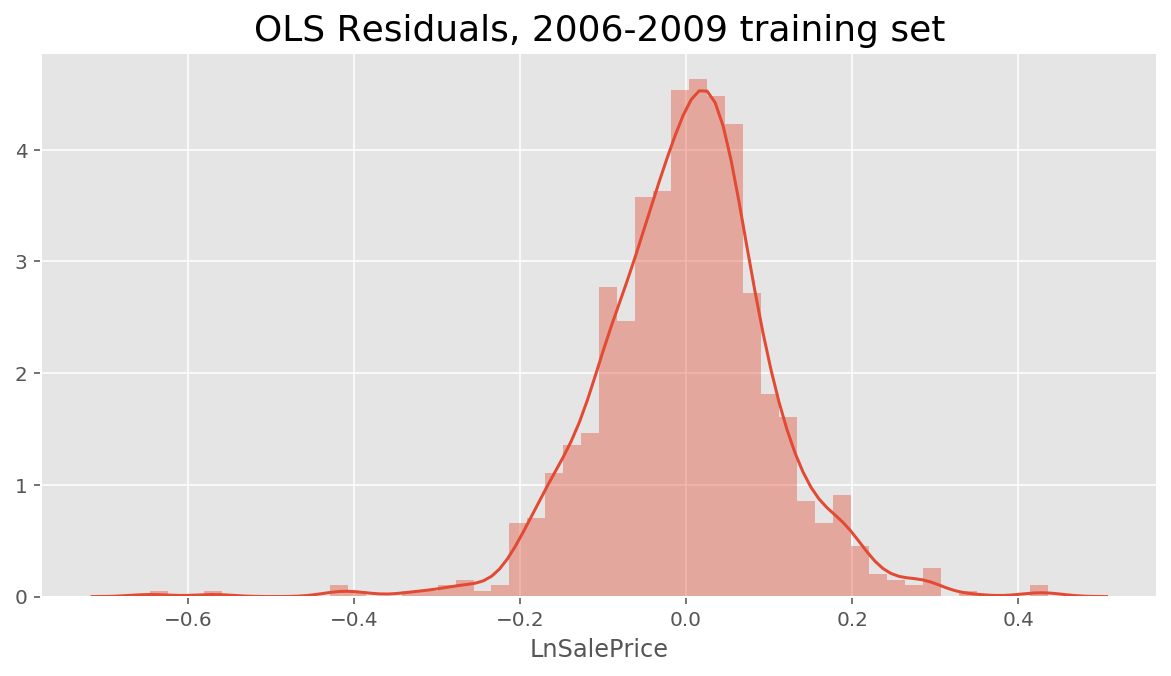

In [113]:
# The residuals are approximately normally distributed with mean 0
# There is an indication of a left-tail, indicating that the model overpredicts the target variable
# at the very low end of 'LnSalePrice'

fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(ols_residuals_0609, bins=50, kde=True, ax=ax)
plt.title('OLS Residuals, 2006-2009 training set', fontsize=18);

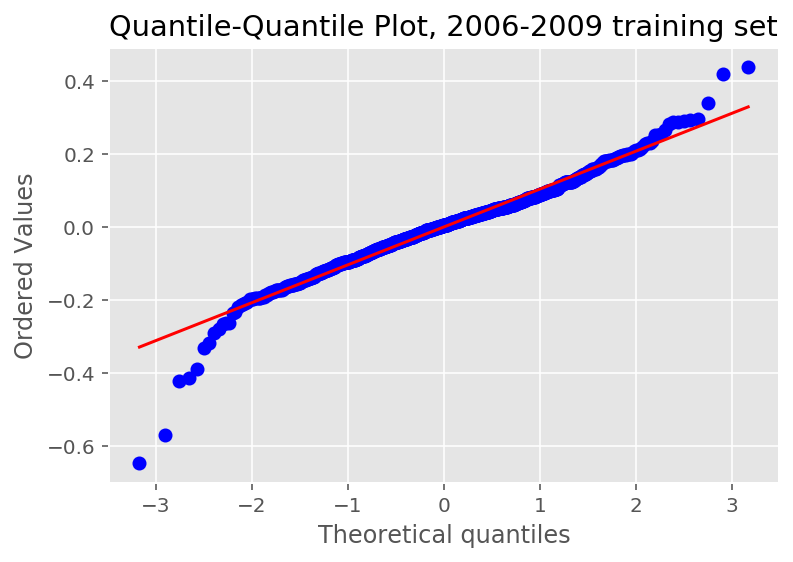

In [114]:
from scipy import stats
stats.probplot(ols_residuals_0609, dist="norm", plot=plt)
plt.title("Quantile-Quantile Plot, 2006-2009 training set");

count    230.000000
mean       0.003783
std        0.112968
min       -0.467448
25%       -0.059655
50%       -0.000455
75%        0.061375
max        0.338498
Name: LnSalePrice, dtype: float64

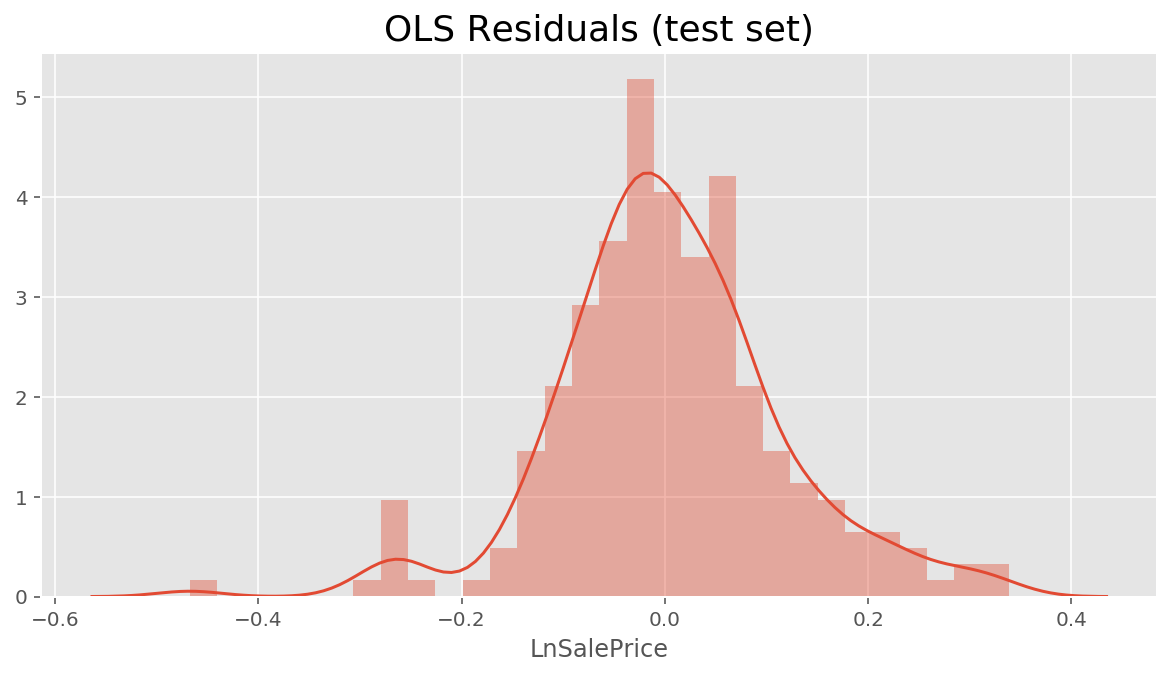

In [115]:
# The distribution of the test predictions are symmetric and approximately normal
ols_residuals_test = (y_test - predictions_test)

fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(ols_residuals_test, bins=30, kde=True, ax=ax)
plt.title('OLS Residuals (test set)', fontsize=18);

ols_residuals_test.describe()

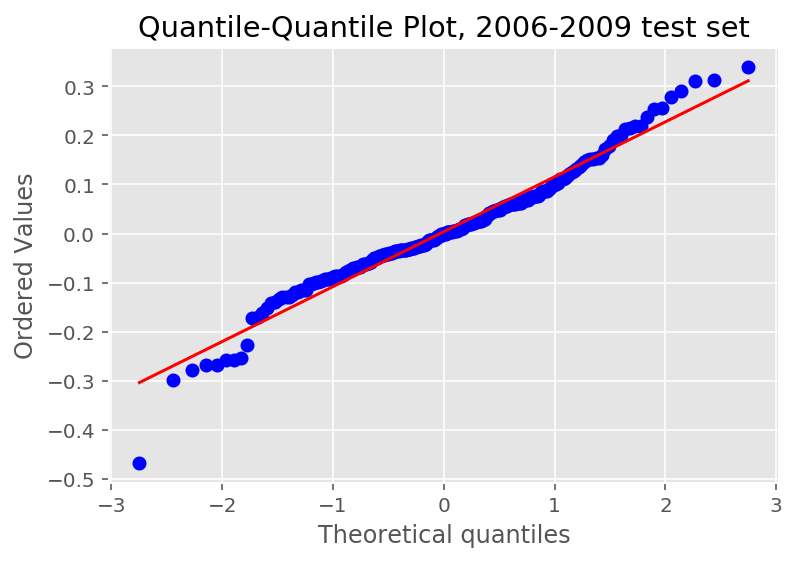

In [116]:
stats.probplot(ols_residuals_test, dist="norm", plot=plt)
plt.title("Quantile-Quantile Plot, 2006-2009 test set");

In [117]:
ols_residuals_test0609 = (y_test - predictions_test)
print("Skew:", ols_residuals_test0609.skew())
print("Kurtosis:", ols_residuals_test0609.kurtosis())
stat, p = shapiro(ols_residuals_test0609)
print('Shapiro-Wilk test on normality=%.3f, p=%.3f' % (stat, p))

Skew: -0.06501384787350127
Kurtosis: 1.7721078782192476
Shapiro-Wilk test on normality=0.971, p=0.000


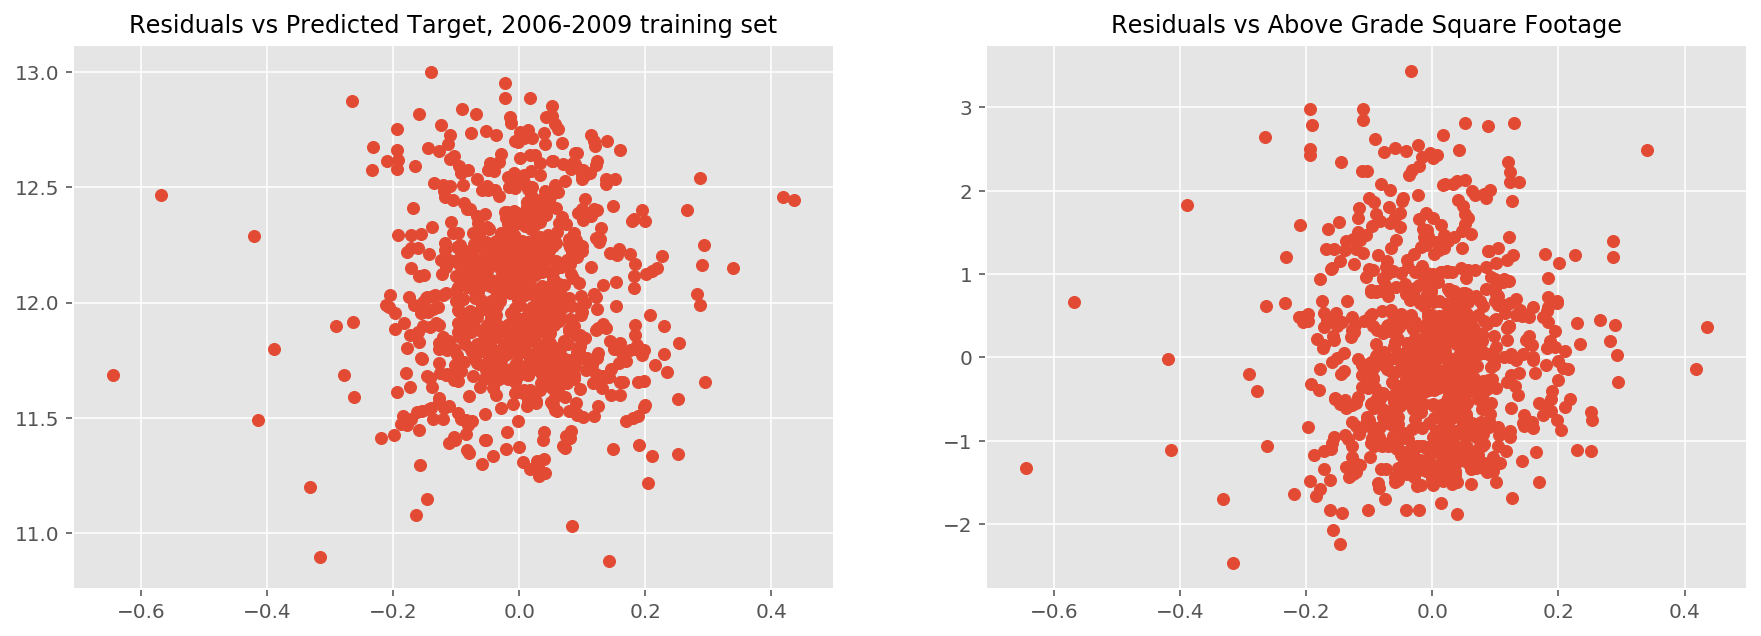

In [118]:
# Plotting the OLS residuals against the predicted-y and 'GrLivArea'. The residuals appear well-behaved
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))
ax[0].scatter(ols_residuals_0609, predictions_train)
ax[0].set_title('Residuals vs Predicted Target, 2006-2009 training set', fontsize=12)
ax[1].scatter(ols_residuals_0609, X_train.GrLivArea)
ax[1].set_title('Residuals vs Above Grade Square Footage', fontsize=12);

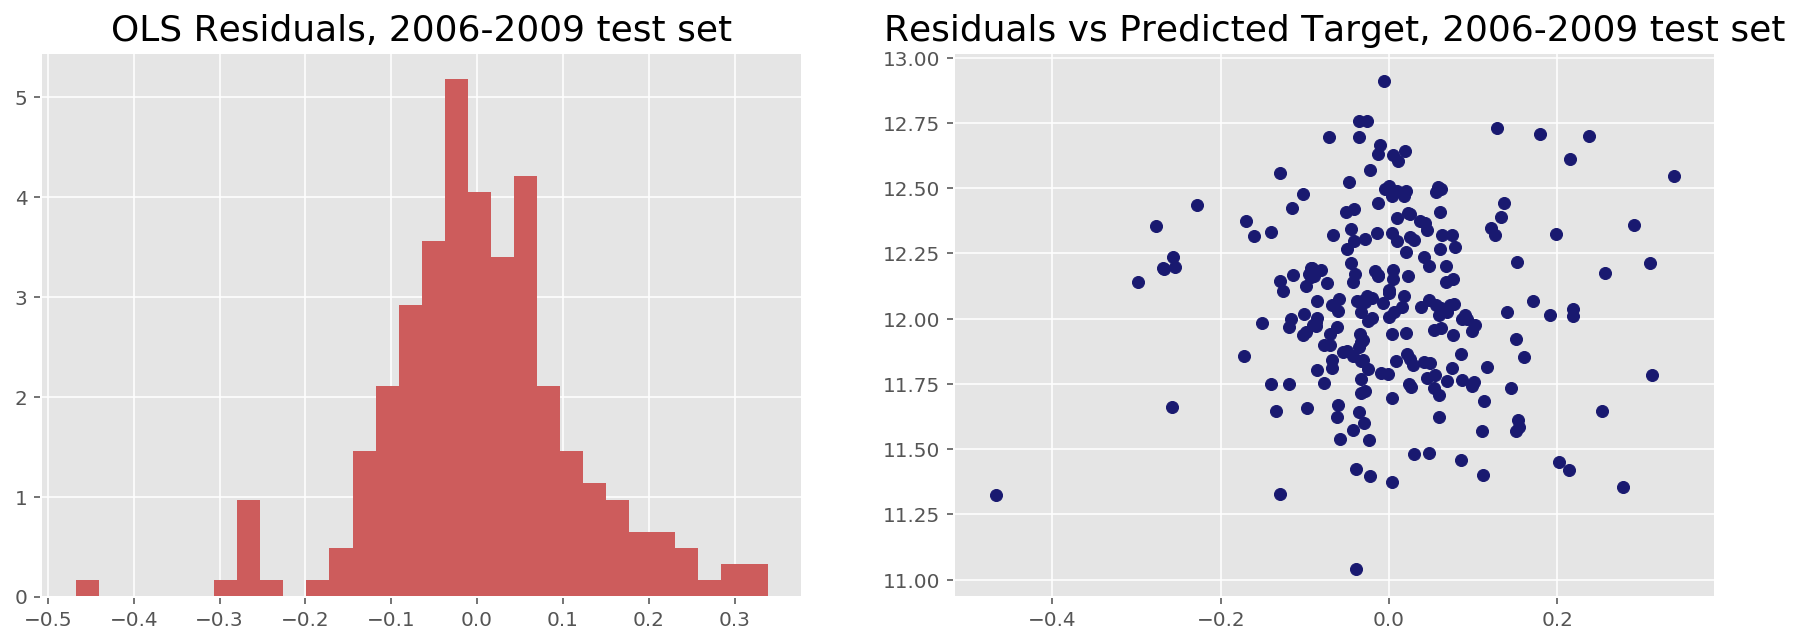

In [119]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))
ax[0].hist(ols_residuals_test, density=True, bins=30, color='indianred')
ax[0].set_title('OLS Residuals, 2006-2009 test set', fontsize=18)
ax[1].scatter(ols_residuals_test, predictions_test, color='midnightblue')
ax[1].set_title('Residuals vs Predicted Target, 2006-2009 test set', fontsize=18);

### Undertaking Ridge & Lasso CV

In [120]:
# Ridge Cross-Validation
ridge_mod = RidgeCV(alphas=np.logspace(-4, 4, 10), cv=5)
ridge_mod.fit(X_train, y_train)

print('Best Ridge alpha:', ridge_mod.alpha_)
print('Training score:', ridge_mod.score(X_train, y_train))
print("Test Score:", ridge_mod.score(X_test, y_test))

Best Ridge alpha: 2.782559402207126
Training score: 0.9177412348655769
Test Score: 0.8955029551246616


In [121]:
df_ridge_coef = pd.DataFrame(ridge_mod.coef_, index=X_train.columns,
                       columns=['Coefficients'])
df_ridge_coef['Coef_abs'] = df_ridge_coef.Coefficients.abs()

In [122]:
# Confirmed similar to the above Ridge CV scores
ridge_mod = Ridge(alpha=2.78)

scores = cross_val_score(ridge_mod, X_train, y_train, cv=5)
print("Cross-validated training scores:", scores)
print("Mean cross-validated training score:", scores.mean())

ridge_mod.fit(X_train, y_train)
print("Training Score:", ridge_mod.score(X_train, y_train))
print("Test Score:", ridge_mod.score(X_test, y_test))

Cross-validated training scores: [0.90348492 0.89595055 0.93220021 0.89871754 0.92014166]
Mean cross-validated training score: 0.91009897578894
Training Score: 0.9177412556550818
Test Score: 0.895503016798522


In [123]:
# Lasso Cross-Validation
lasso_mod = LassoCV(alphas=np.logspace(-4, 4, 10), cv=5)
lasso_mod.fit(X_train, y_train)

print('Best Lasso alpha:', lasso_mod.alpha_)
print('Training score:', lasso_mod.score(X_train, y_train))
print("Test Score:", lasso_mod.score(X_test, y_test))

Best Lasso alpha: 0.000774263682681127
Training score: 0.9176279083015472
Test Score: 0.8947459483511776


In [124]:
df_lasso_coef = pd.DataFrame(lasso_mod.coef_, index=X_train.columns,
                       columns=['Coefficients'])
df_lasso_coef['Coef_abs'] = df_lasso_coef.Coefficients.abs()

Both the coefficients and R-squared of the models I have used above appear very stable (so low variance) across the OLS, Ridge and Lasso models. The R-squared is approximately 0.86 across all 3 models, and across the training and test sets too.

In [125]:
coef_0609 = pd.concat([df_ols_coef['Coefficients'], df_ridge_coef['Coefficients'], df_lasso_coef['Coefficients']])
coef_0609 = pd.DataFrame(coef_0609)

In [126]:
coef_0609.reset_index(level=0, inplace=True)
coef_0609.columns = ['variable', 'coefficient']
coef_0609

,variable,coefficient
0,Age,-0.083023
1,GrLivArea,0.158011
2,BaseLivArea,0.047286
3,Location,0.034660
4,Amenities,-0.003321
...,...,...
76,Zoning_3,0.021389
77,Zoning_4,0.013783
78,YrSold_2007,0.001235
79,YrSold_2008,0.002232


In [127]:
coef_0609.loc[0:26, "model"] = "ols"
coef_0609.loc[27:53, "model"] = "ridge"
coef_0609.loc[54:80, "model"] = "lasso"

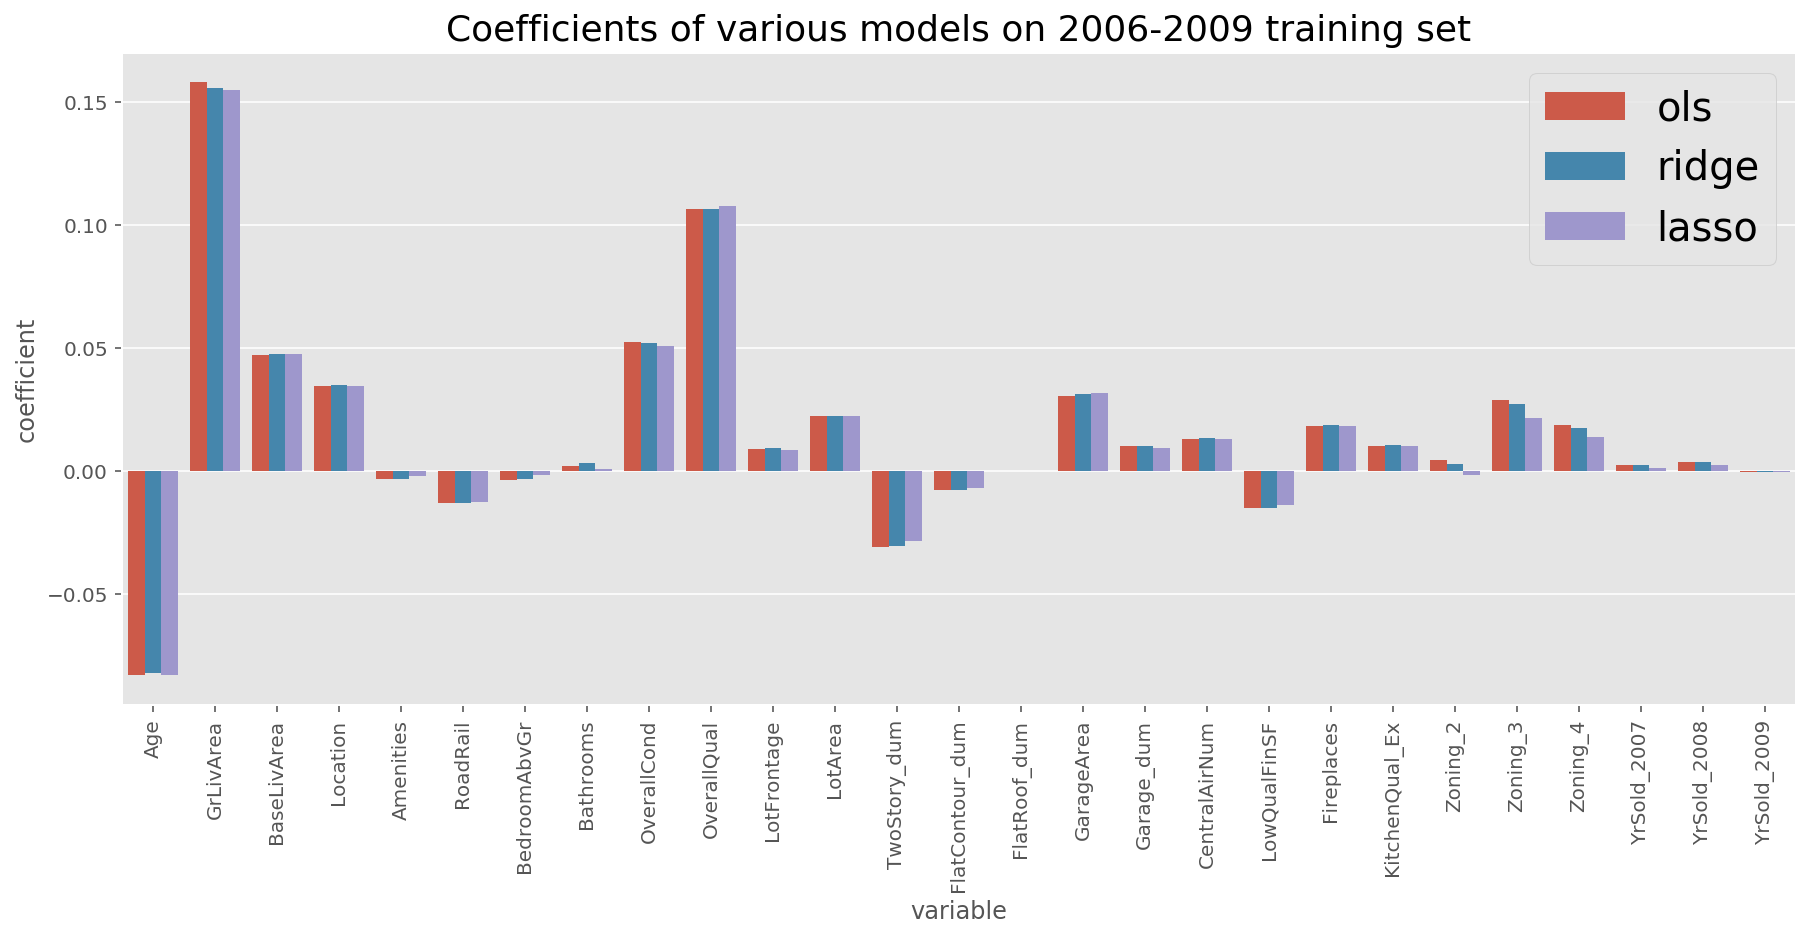

In [128]:
fig, ax = plt.subplots(figsize=(15,6))

sns.catplot(x='variable', y='coefficient', hue='model', data=coef_0609, kind='bar', ax=ax)
ax.set_title('Coefficients of various models on 2006-2009 training set', fontsize=18)
ax.set_xticklabels(labels=coef_0609.variable, rotation=90)
ax.legend(fontsize=20)
plt.close(2)
plt.show()

Rather consistent coefficient estimates and R-squared readings across the OLS, Ridge and Lasso regression models. Training set scores of approximately 0.92, and test set scores around 0.89-0.90.

# Refitting then testing the model on the 2010 holdout data

In [129]:
y_train = df_0609['LnSalePrice']
y_lnSP_2010 = df_2010['LnSalePrice']

In [130]:
X_2010 = df_2010[['Age', 'GrLivArea', 'BaseLivArea', 'Location', 'Amenities', 'RoadRail', 'BedroomAbvGr', 'Bathrooms', 
                  'OverallCond', 'OverallQual', 'LotFrontage', 'LotArea', 'TwoStory_dum', 'FlatContour_dum', 'FlatRoof_dum', 
                  'GarageArea', 'Garage_dum', 'CentralAirNum', 'LowQualFinSF', 'Fireplaces', 'KitchenQual_Ex', 
                  'Zoning_2', 'Zoning_3', 'Zoning_4', 'YrSold_2007', 'YrSold_2008', 'YrSold_2009']]

In [131]:
# Using the full 2006-2009 data to fit the linear regression
X_train = df_0609[['Age', 'GrLivArea', 'BaseLivArea', 'Location', 'Amenities', 'RoadRail', 'BedroomAbvGr', 'Bathrooms', 
                  'OverallCond', 'OverallQual', 'LotFrontage', 'LotArea', 'TwoStory_dum', 'FlatContour_dum', 'FlatRoof_dum', 
                  'GarageArea', 'Garage_dum', 'CentralAirNum', 'LowQualFinSF', 'Fireplaces', 'KitchenQual_Ex', 
                  'Zoning_2', 'Zoning_3', 'Zoning_4', 'YrSold_2007', 'YrSold_2008', 'YrSold_2009']]

In [132]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_2010), columns=X_2010.columns)

In [133]:
ols.fit(X_train, y_train) 
predictions_train = ols.predict(X_train)
predictions_test = ols.predict(X_test)

In [134]:
# 5-fold cross-validation, with rather consistent results from the training set both individually and together
cv_scores = cross_val_score(ols, X_train, y_train, cv=5)

print('Training Score:', ols.score(X_train, y_train))
print('Cross validation score:', cv_scores)
print('Mean cross validation score:', cv_scores.mean())
print('2010 holdout data score:', ols.score(X_test, y_lnSP_2010))

Training Score: 0.9142892027291004
Cross validation score: [0.91650916 0.92252336 0.89605686 0.90380737 0.88971643]
Mean cross validation score: 0.9057226373960698
2010 holdout data score: 0.8873163698088462


In [135]:
print('Mean Squared Error:', metrics.mean_squared_error(y_lnSP_2010, predictions_test)) 
print('Root Mean Squared Error:', (metrics.mean_squared_error(y_lnSP_2010, predictions_test))**0.5) 

Mean Squared Error: 0.014474508804942764
Root Mean Squared Error: 0.12031005280084771


In [136]:
ols_residuals_2010 = (y_lnSP_2010 - predictions_test)
ols_residuals_2010.describe()

count    157.000000
mean       0.013889
std        0.119888
min       -0.407312
25%       -0.065531
50%        0.024257
75%        0.088925
max        0.340542
Name: LnSalePrice, dtype: float64

In [137]:
print("Skew:", ols_residuals_2010.skew())
print("Kurtosis:", ols_residuals_2010.kurtosis())
stat, p = shapiro(ols_residuals_2010)
print('Shapiro-Wilk test on normality=%.3f, p=%.3f' % (stat, p))

Skew: -0.4620602343310066
Kurtosis: 0.7264674248836478
Shapiro-Wilk test on normality=0.984, p=0.071


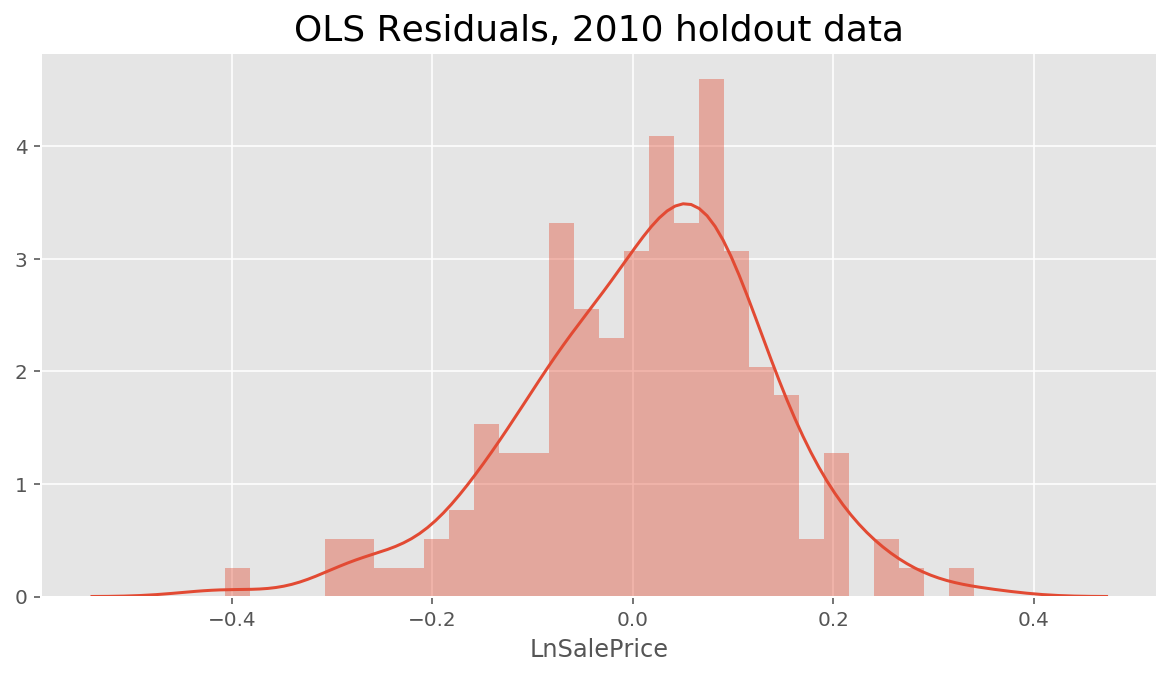

In [138]:
# For the 2010 test data, the residuals are approximately symmetric with a slight left-tail,
# and a mean centred near zero but slightly positive
ols_residuals_2010 = (y_lnSP_2010 - predictions_test)

fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(ols_residuals_2010, bins=30, kde=True, ax=ax)
plt.title('OLS Residuals, 2010 holdout data', fontsize=18);

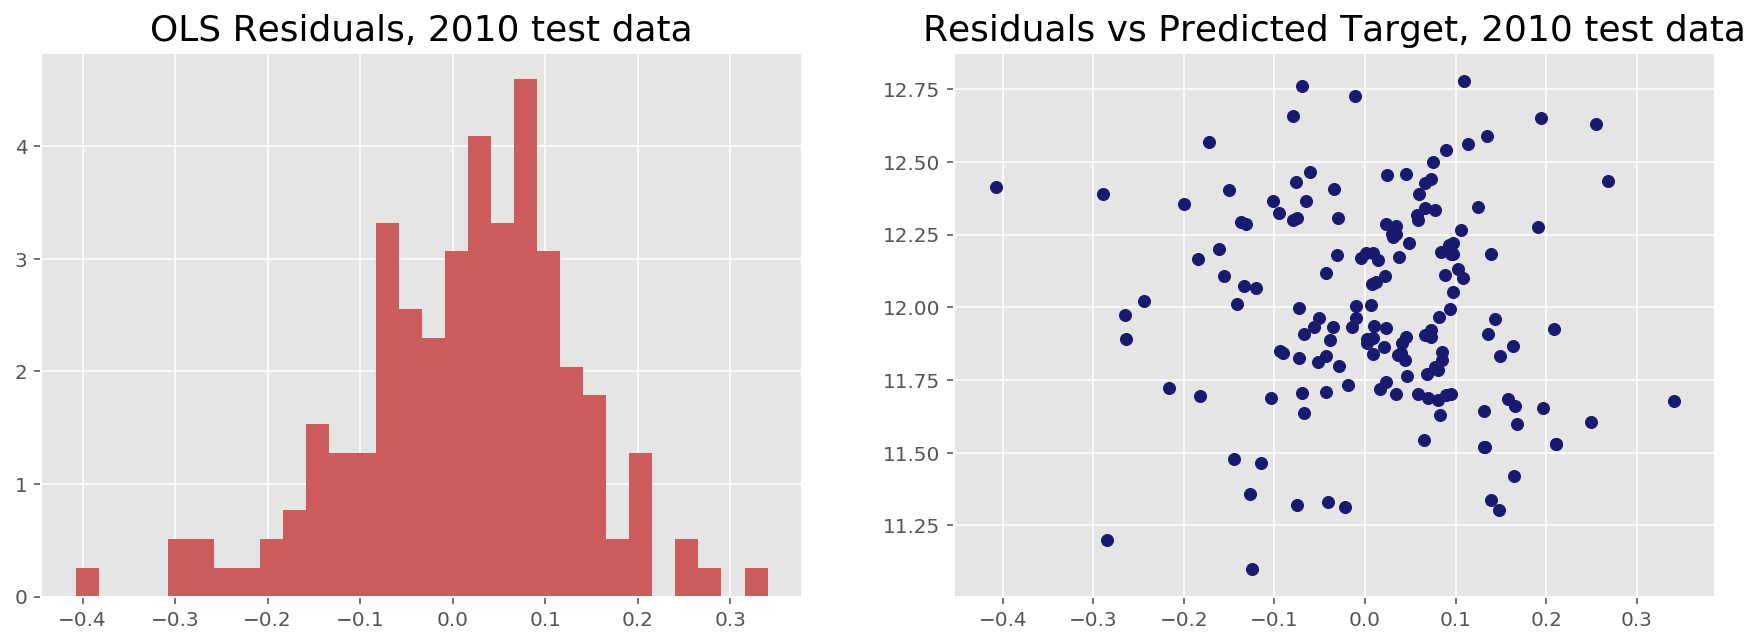

In [139]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))
ax[0].hist(ols_residuals_2010, density=True, bins=30, color='indianred')
ax[0].set_title('OLS Residuals, 2010 test data', fontsize=18)
ax[1].scatter(ols_residuals_2010, predictions_test, color='midnightblue')
ax[1].set_title('Residuals vs Predicted Target, 2010 test data', fontsize=18);

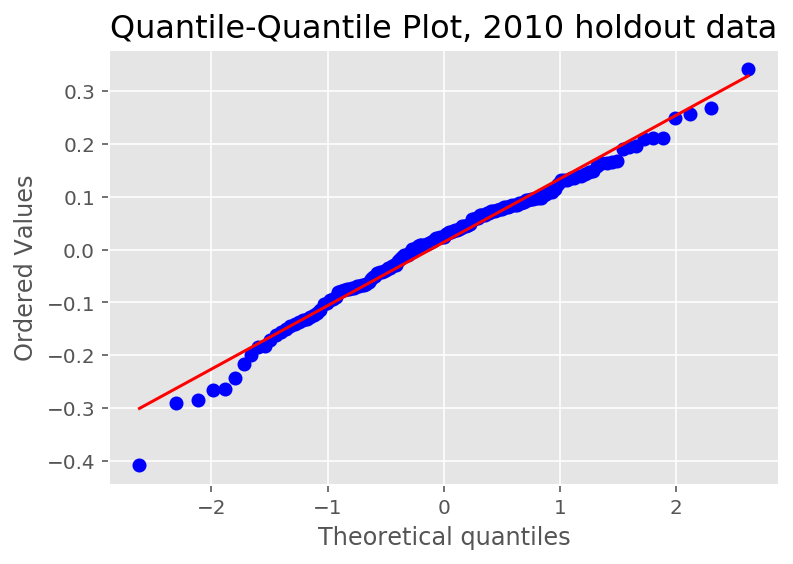

In [140]:
from scipy import stats
stats.probplot(ols_residuals_2010, dist="norm", plot=plt)
plt.title("Quantile-Quantile Plot, 2010 holdout data", fontsize=16)
plt.show()

In [141]:
ridge_mod = RidgeCV(alphas=np.logspace(-4, 4, 10), cv=5)
ridge_mod.fit(X_train, y_train)

print('Best Ridge alpha:', ridge_mod.alpha_)
print('Training score:', ridge_mod.score(X_train, y_train))
print("2010 holdout data score:", ridge_mod.score(X_test, y_lnSP_2010))

Best Ridge alpha: 2.782559402207126
Training score: 0.9142807716160317
2010 holdout data score: 0.8874877722956822


In [142]:
lasso_mod = LassoCV(alphas=np.logspace(-4, 4, 10), cv=5)
lasso_mod.fit(X_train, y_train)

print('Best Lasso alpha:', lasso_mod.alpha_)
print('Training score:', lasso_mod.score(X_train, y_train))
print("2010 holdout data score:", lasso_mod.score(X_test, y_lnSP_2010))

Best Lasso alpha: 0.000774263682681127
Training score: 0.9141203936674898
2010 holdout data score: 0.8876194839625287


Using the 2010 data as the test set, we see that the R-squared drops slightly to 0.89 in the test set from the 0.91 achieved in the 2006-2009 training set. The residuals of the test set has a distribution with a very slight positive mean value and a longer left-tail, but it looks approximately normal. The results again appear consistent across the OLS, Ridge and Lasso regressions.

# Regression model using full 2006-2010 data

In [143]:
y_lnSP = df_exout['LnSalePrice']
y_lnPSF = df_exout['LnPriceSF']

In [144]:
X_fin = df_exout[['Age', 'GrLivArea', 'BaseLivArea', 'Location', 'Amenities', 'RoadRail', 'BedroomAbvGr', 'Bathrooms', 
                  'OverallCond', 'OverallQual', 'LotFrontage', 'LotArea', 'TwoStory_dum', 'FlatContour_dum', 'FlatRoof_dum', 
                  'GarageArea', 'Garage_dum', 'CentralAirNum', 'LowQualFinSF', 'Fireplaces', 'KitchenQual_Ex', 
                  'Zoning_2', 'Zoning_3', 'Zoning_4', 'YrSold_2007', 'YrSold_2008', 'YrSold_2009', 'YrSold_2010']]

In [145]:
X_fin.shape

(1305, 28)

In [146]:
X_fin = pd.DataFrame(scaler.fit_transform(X_fin), columns=X_fin.columns)

In [147]:
ols.fit(X_fin, y_lnSP) 
predictions = ols.predict(X_fin)
print('R-squared:', ols.score(X_fin, y_lnSP))
print('Mean Squared Error:', metrics.mean_squared_error(y_lnSP, predictions))  
print('Root Mean Squared Error:', (metrics.mean_squared_error(y_lnSP, predictions))**0.5)  

R-squared: 0.9115386685200919
Mean Squared Error: 0.011635978224627702
Root Mean Squared Error: 0.10787019154811815


In [148]:
df_LnSP_coef = pd.DataFrame(ols.coef_, index=X_fin.columns,
                       columns=['Coefficients'])
df_LnSP_coef['Coef_abs'] = df_LnSP_coef.Coefficients.abs()

In [149]:
error_term = (y_lnSP - predictions)
error_term.describe()

count    1.305000e+03
mean     2.137073e-16
std      1.079115e-01
min     -6.407018e-01
25%     -6.105849e-02
50%      4.215856e-03
75%      6.023444e-02
max      4.553470e-01
Name: LnSalePrice, dtype: float64

In [150]:
# Residuals are approximately normal, given the skew and kurtosis
print("Skew:", error_term.skew())
print("Kurtosis:", error_term.kurtosis())
stat, p = shapiro(error_term)
print('Shapiro-Wilk test on normality=%.3f, p=%.3f' % (stat, p))

Skew: -0.34924925476823854
Kurtosis: 2.746433693905747
Shapiro-Wilk test on normality=0.974, p=0.000


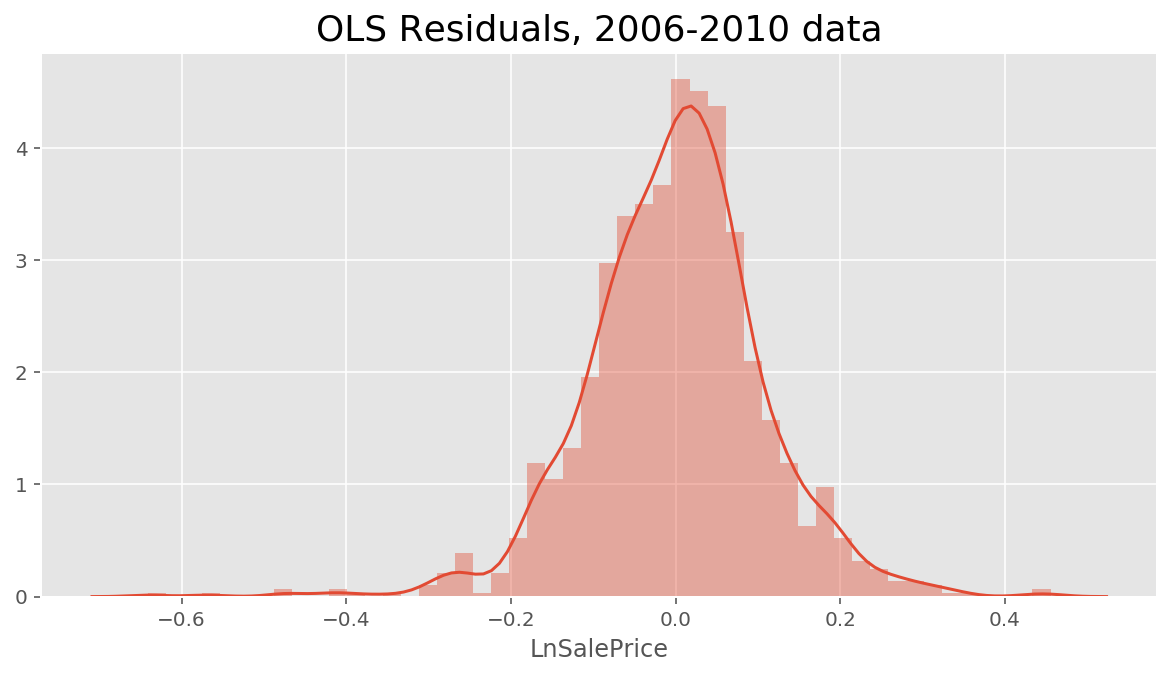

In [151]:
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(error_term, bins=50, kde=True, ax=ax)
plt.title('OLS Residuals, 2006-2010 data', fontsize=18)
plt.show()

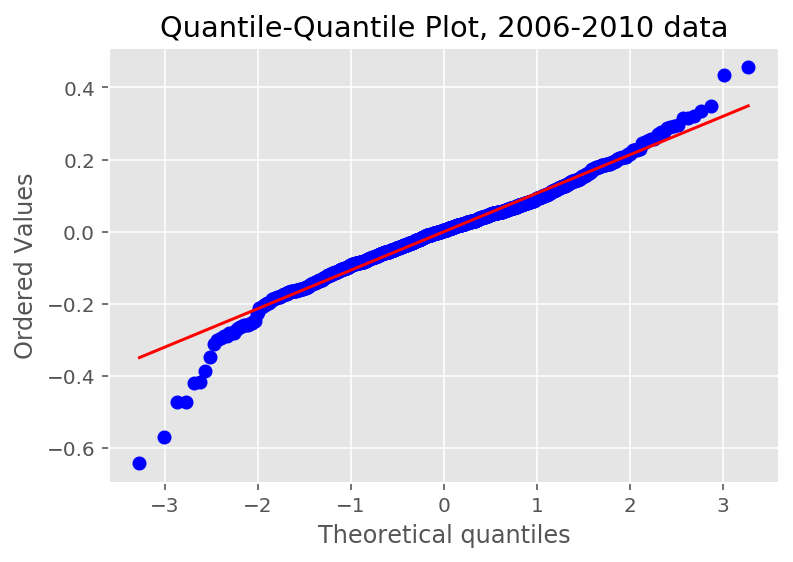

In [152]:
from scipy import stats
stats.probplot(error_term, dist="norm", plot=plt)
plt.title("Quantile-Quantile Plot, 2006-2010 data")
plt.show()

# Statistical inference and hypothesis testing

In [153]:
# Doing the unscaled regression to get the unstandardised coefficients
X_fin = df_exout[['Age', 'GrLivArea', 'BaseLivArea', 'Location', 'Amenities', 'RoadRail', 'BedroomAbvGr', 'Bathrooms', 
                  'OverallCond', 'OverallQual', 'LotFrontage', 'LotArea', 'TwoStory_dum', 'FlatContour_dum', 'FlatRoof_dum', 
                  'GarageArea', 'Garage_dum', 'CentralAirNum', 'LowQualFinSF', 'Fireplaces', 'KitchenQual_Ex', 
                  'Zoning_2', 'Zoning_3', 'Zoning_4', 'YrSold_2007', 'YrSold_2008', 'YrSold_2009', 'YrSold_2010']]

In [154]:
ols.fit(X_fin, y_lnSP)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [155]:
df_unscaled_coef = pd.DataFrame(ols.coef_, index=X_fin.columns, columns=['Coefficients'])
df_unscaled_coef['Coef_abs'] = df_unscaled_coef.Coefficients.abs()
df_unscaled_coef

,Coefficients,Coef_abs
Age,-0.002765,0.002765
GrLivArea,0.000332,0.000332
BaseLivArea,0.000102,0.000102
Location,0.030592,0.030592
Amenities,-0.040443,0.040443
RoadRail,-0.047799,0.047799
BedroomAbvGr,-0.007939,0.007939
Bathrooms,0.003611,0.003611
OverallCond,0.048863,0.048863
OverallQual,0.080016,0.080016


In [156]:
import math

transformed_coef = []
for x in df_unscaled_coef.iloc[:,0]:
    y = math.exp(x)
    transformed_coef.append(y)
print(transformed_coef)

[0.9972388959442907, 1.000331834299945, 1.000102423760994, 1.0310643167521516, 0.9603636039253578, 0.9533258139743109, 0.9920928445716828, 1.0036176139626916, 1.0500767818575054, 1.0833041802871985, 1.0006339970501181, 1.0000027052269853, 0.9440567842451411, 0.9820777440647303, 1.0320184686046414, 1.0001497401266548, 1.0442373168994357, 1.0601280936216115, 0.9996666730381296, 1.0260320873433462, 1.0740463441232837, 1.0302554777469248, 1.0930086257876308, 1.1136897864018394, 1.006334264289974, 1.0098223332945244, 0.9980218396265257, 1.014390715365613]


In [157]:
coef_effect = [(x - 1)*df_exout.SalePrice.mean() for x in transformed_coef]
print(coef_effect)

[-492.7978128226541, 59.22530043527076, 18.28044303310284, 5544.313811946485, -7074.2459898848165, -8330.340445220445, -1411.2575339803761, 645.6664480879671, 8937.630771845907, 14868.00823736788, 113.15486607185098, 0.482824955036947, -9984.663312219272, -3198.73802201922, 5714.6094388119045, 26.725398760214496, 7895.411608304793, 10731.574192090418, -59.49170855219682, 4646.168868385452, 13215.683181521428, 5399.953409491818, 16600.04347428008, 20291.186767573283, 1130.5302244894735, 1753.0756779513474, -353.0591697349729, 2568.433827208929]


### Coefficient standard errors and p-values

In [158]:
# Model using full 2006-2010 data with unstandardised values, featuring individual coefficients with p-values
from regressors import stats

ols = linear_model.LinearRegression()
ols.fit(X_fin, y_lnSP)

print("\n================ SUMMARY TABLE WITH P-VALUES =================")
xlabels = X_fin.columns
stats.summary(ols, X_fin, y_lnSP, xlabels)


================ SUMMARY TABLE WITH P-VALUES =================
Residuals:
    Min      1Q  Median      3Q     Max
-0.4553 -0.0602 -0.0042  0.0611  0.6407


Coefficients:
                  Estimate  Std. Error   t value   p value
_intercept       10.462900    0.041655  251.1786  0.000000
Age              -0.002765    0.000102  -27.2362  0.000000
GrLivArea         0.000332    0.000004   76.7559  0.000000
BaseLivArea       0.000102    0.000007   15.0437  0.000000
Location          0.030592    0.003365    9.0900  0.000000
Amenities        -0.040443    0.021899   -1.8468  0.065005
RoadRail         -0.047799    0.012767   -3.7439  0.000189
BedroomAbvGr     -0.007939    0.004971   -1.5971  0.110493
Bathrooms         0.003611    0.008756    0.4124  0.680095
OverallCond       0.048863    0.002752   17.7562  0.000000
OverallQual       0.080016    0.003247   24.6447  0.000000
LotFrontage       0.000634    0.000141    4.4887  0.000008
LotArea           0.000003    0.000000   10.8102  0.000000
Two